## Imports

In [227]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import missingno as msno
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
pd.set_option('display.max_columns', None)
from sktime.forecasting.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import seaborn as sns
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX as StatsmodelsSARIMAX
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from prophet import Prophet
import time

In [228]:
#surpress warnings

warnings.filterwarnings("ignore")

## Load data

In [229]:
def load_data(path):
    df = pd.read_csv(path, parse_dates=['datetime'])
    df = df.sort_index()
    columns_to_drop = ['Unnamed: 0', 'sunrise', 'sunset']
    df = df.drop(columns=columns_to_drop)
    df['datetime'] = pd.to_datetime(df['datetime'])

    last_year = df['datetime'].max() - pd.DateOffset(years=1)
    df_last_year = df[df['datetime'] >= last_year]
    df = df.sort_values('datetime')
    
    return df, df_last_year


In [230]:
df_london, df_last_year_london = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\london_weather_2014-2024.csv')
df_manila, df_last_year_manila = load_data(r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\manila_weather_2014-2024.csv')


In [231]:
df_london.head()

name   datetime  tempmax  tempmin  temp  \
0  London, England, United Kingdom 2014-01-01     11.6      6.7   9.1   
1  London, England, United Kingdom 2014-01-02     11.0      6.6   9.1   
2  London, England, United Kingdom 2014-01-03     10.6      7.3   9.0   
3  London, England, United Kingdom 2014-01-04     10.1      4.5   8.0   
4  London, England, United Kingdom 2014-01-05     12.0      1.8   6.0   

   feelslikemax  feelslikemin  feelslike  dew  humidity  precip  precipprob  \
0          11.6           3.6        7.0  6.7      84.8  11.857         100   
1          11.0           3.6        7.2  6.0      81.0   5.394         100   
2          10.6           3.2        6.5  5.1      76.8   6.030         100   
3          10.1           2.0        5.1  5.2      82.4   5.239         100   
4          12.0          -0.9        3.6  3.9      85.9   0.201         100   

   precipcover preciptype  snow  snowdepth  windgust  windspeed  winddir  \
0        16.67       rain   0.0        0.0      72.4       38.4    190.5   
1        12.50       rain   0.0        0.0      51.8       29.8    216.2   
2        16.67       rain   0.0        0.0      77.4       33.5    218.4   
3        16.67       rain   0.0        0.0      62.1       29.2    206.0   
4         8.33       rain   0.0        0.0      55.6       30.4    192.5   

   sealevelpressure  cloudcover  visibility  solarradiation  solarenergy  \
0             993.1        67.4        14.2             6.9          0.5   
1             993.4        47.4        26.7            38.3          3.3   
2             994.5        52.8        17.9            30.3          2.8   
3             993.6        67.6        22.0            17.4          1.4   
4            1000.0        66.5        25.5            30.4          2.6   

   uvindex  severerisk  moonphase              conditions  \
0        0         NaN       0.00  Rain, Partially cloudy   
1        2         NaN       0.03  Rain, Partially cloudy   
2        2         NaN       0.07  Rain, Partially cloudy   
3        1         NaN       0.10  Rain, Partially cloudy   
4        2         NaN       0.14  Rain, Partially cloudy   

                                         description  icon  \
0  Partly cloudy throughout the day with a chance...  rain   
1        Partly cloudy throughout the day with rain.  rain   
2  Partly cloudy throughout the day with a chance...  rain   
3  Partly cloudy throughout the day with a chance...  rain   
4        Partly cloudy throughout the day with rain.  rain   

                                            stations  
0  03769099999,EGWU,03680099999,03768399999,03672...  
1  03769099999,03680099999,03672099999,0378109999...  
2  03769099999,03680099999,03672099999,0378109999...  
3  03769099999,03680099999,03672099999,0378109999...  
4  03769099999,03680099999,03672099999,0378109999...

## Testing for stationarity of the data

As this is a time series comparative study, there is a need to understand the if the data is stationary. 

- https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
- https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322?gi=334565268e20

In [232]:
def test_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print('TS is stationary')
    else:
        print('TS not stationary')

In [233]:
test_stationarity(df_manila['temp'])

ADF Statistic: -6.139003242410702
p-value: 8.0561165344187e-08
TS is stationary


In [234]:
# data is stationary therefore it will not be needing differantiation

## Descriptive statistics and EDA

In [235]:
def descriptive_stats(df):
    print("shape: ", df.shape)
    print("column headers: ", df.columns)
    print("first date in series: ", df_london['datetime'].min())
    print("last date in series: ", df_london['datetime'].max())
    print("minimum temperature: ", df_london['temp'].min())
    print("maximum temperature: ", df_london['temp'].max())
    print("missing data: ", df_london.isna().sum())
    print("descriptive statistics: ", df_london.describe())
    print("df info: ", df_london.info())
    print("number of missing values per column: ", df_london.isnull().sum())

In [236]:
descriptive_stats(df_london)

shape:  (3793, 31)
column headers:  Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase',
       'conditions', 'description', 'icon', 'stations'],
      dtype='object')
first date in series:  2014-01-01 00:00:00
last date in series:  2024-05-20 00:00:00
minimum temperature:  -3.2
maximum temperature:  30.3
missing data:  name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
sno

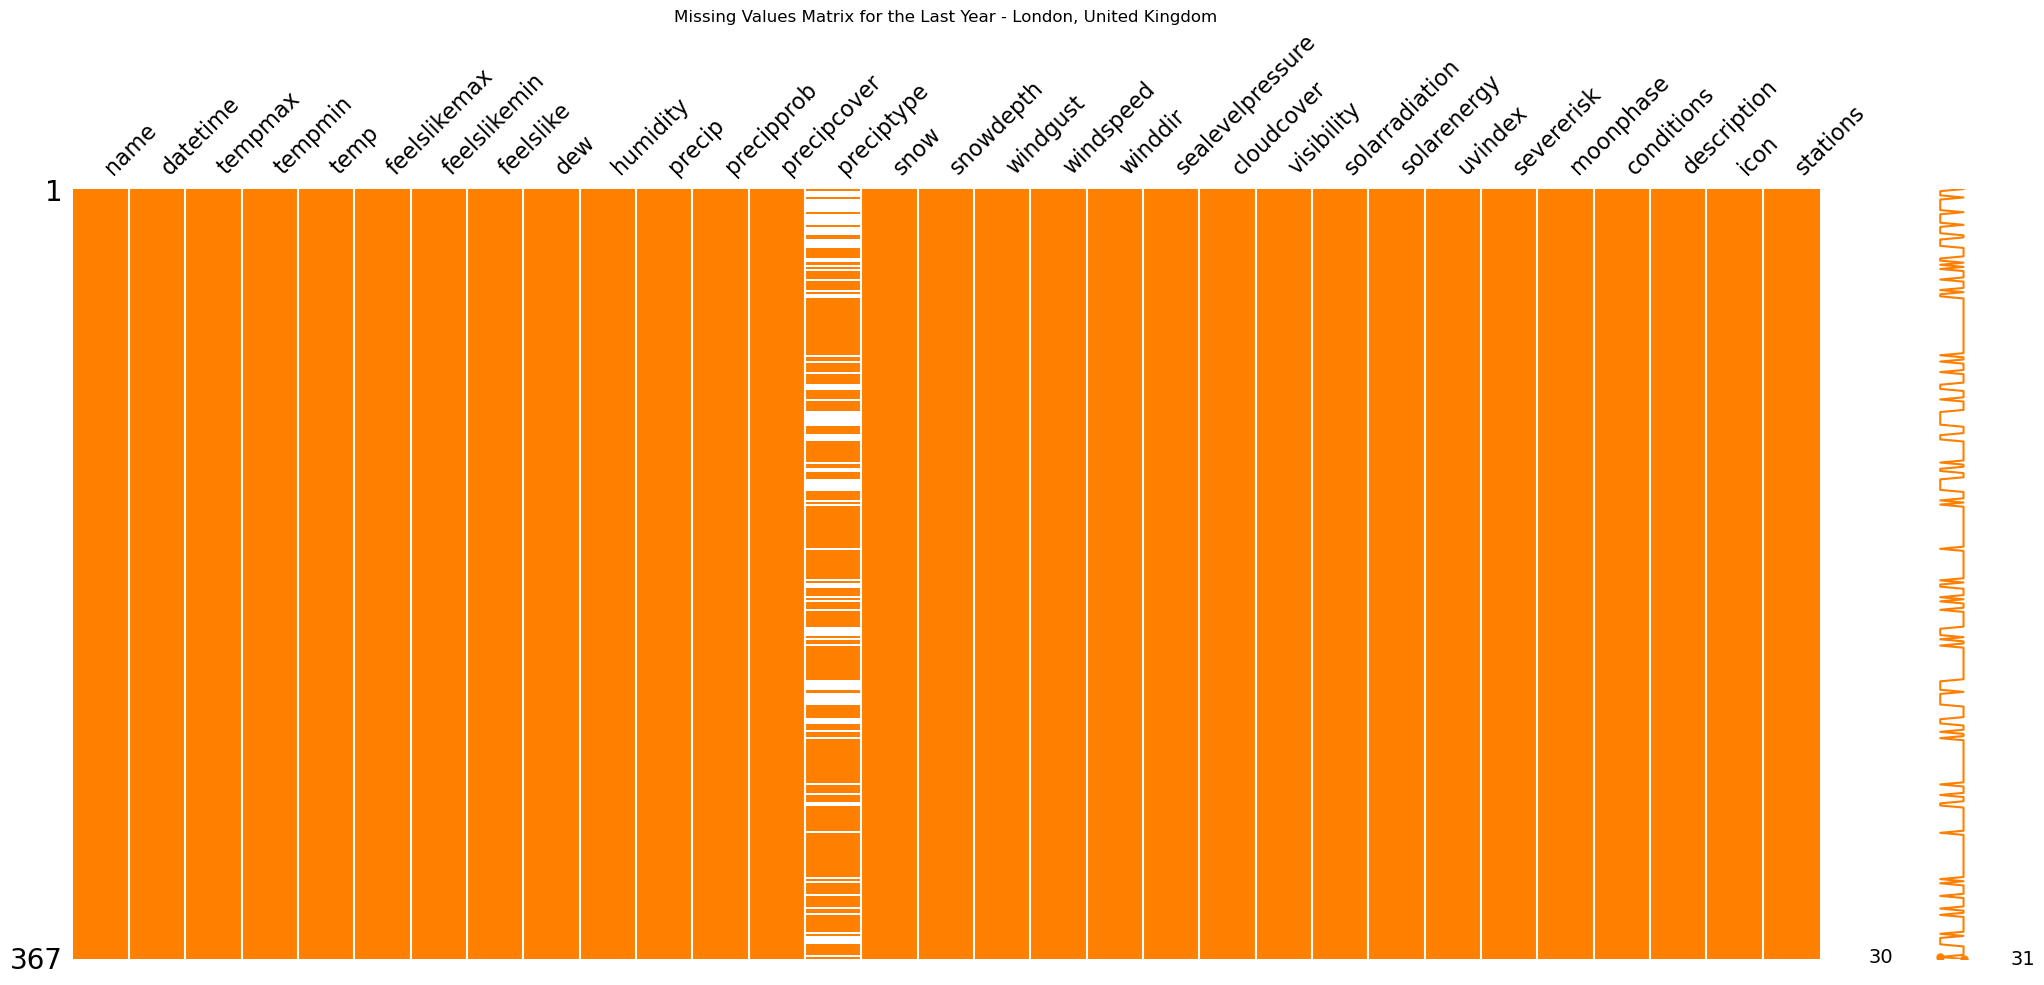

In [237]:
#checking for missing values

msno.matrix(df_last_year_london, color=(1.0, 0.5, 0.0))
plt.title('Missing Values Matrix for the Last Year - London, United Kingdom')

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\missing_values_matrix.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

<Figure size 1200x1000 with 0 Axes>

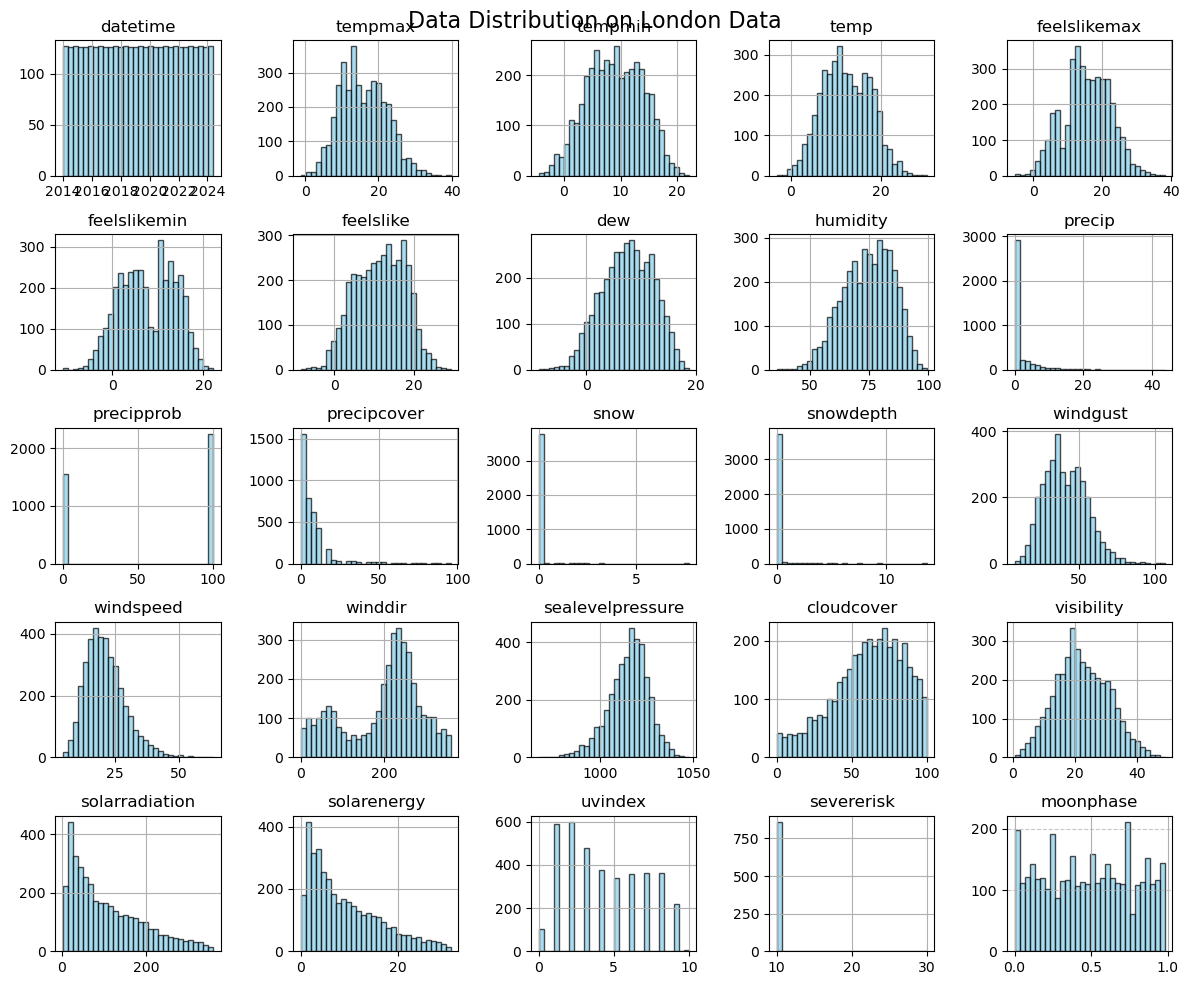

In [238]:
#checking data distribution
plt.figure(figsize=(12, 10))
df_london.hist(bins=30, color='skyblue', edgecolor='black', alpha=0.7, figsize=(12, 10))
plt.tight_layout()
plt.suptitle("Data Distribution on London Data", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\data-distribution.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 
plt.show()

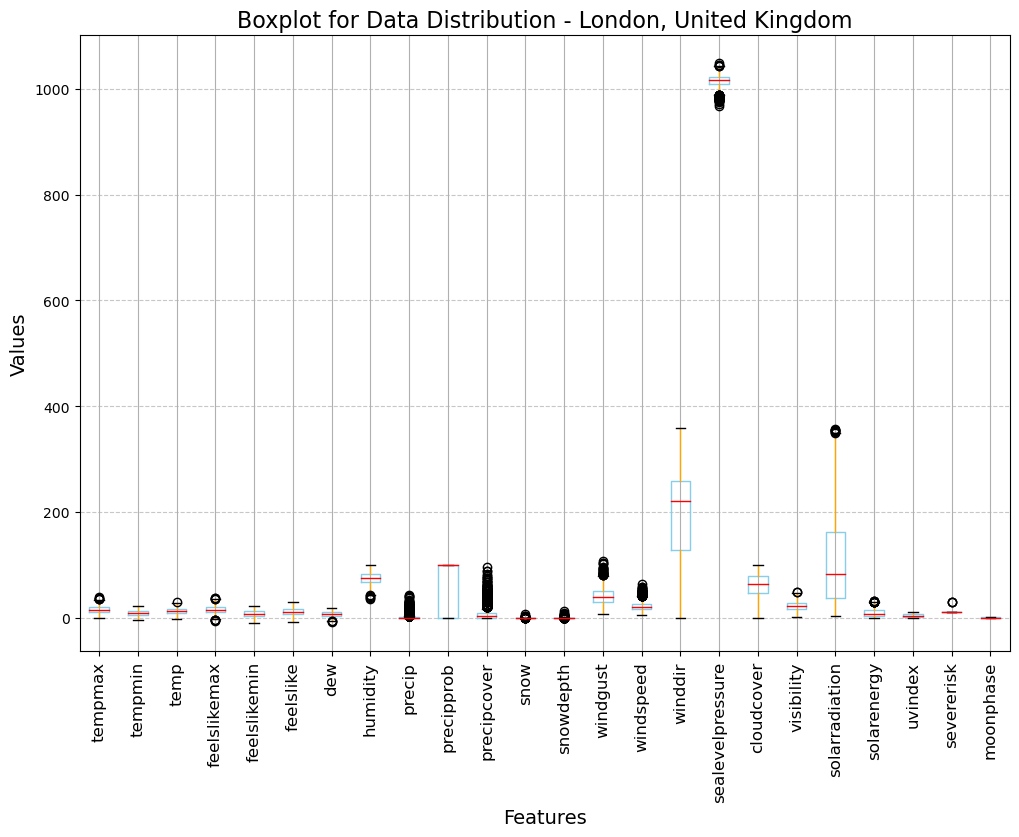

In [239]:
#data distribution
plt.figure(figsize=(12, 8))
df_london.boxplot(figsize=(12, 8), color={'boxes': 'skyblue', 'whiskers': 'orange', 'medians': 'red', 'caps': 'black'})
plt.xticks(rotation=90, fontsize=12)
plt.title('Boxplot for Data Distribution - London, United Kingdom', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\data-distribution2.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [240]:
#creating the correlation between features, for feature importance later on and heatmap
df_london_for_corr = df_london.drop(['name', 'preciptype', 'conditions','description','icon', 'stations'],axis=1)

In [241]:
df_london_for_corr.head()

datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0 2014-01-01     11.6      6.7   9.1          11.6           3.6        7.0   
1 2014-01-02     11.0      6.6   9.1          11.0           3.6        7.2   
2 2014-01-03     10.6      7.3   9.0          10.6           3.2        6.5   
3 2014-01-04     10.1      4.5   8.0          10.1           2.0        5.1   
4 2014-01-05     12.0      1.8   6.0          12.0          -0.9        3.6   

   dew  humidity  precip  precipprob  precipcover  snow  snowdepth  windgust  \
0  6.7      84.8  11.857         100        16.67   0.0        0.0      72.4   
1  6.0      81.0   5.394         100        12.50   0.0        0.0      51.8   
2  5.1      76.8   6.030         100        16.67   0.0        0.0      77.4   
3  5.2      82.4   5.239         100        16.67   0.0        0.0      62.1   
4  3.9      85.9   0.201         100         8.33   0.0        0.0      55.6   

   windspeed  winddir  sealevelpressure  cloudcover  visibility  \
0       38.4    190.5             993.1        67.4        14.2   
1       29.8    216.2             993.4        47.4        26.7   
2       33.5    218.4             994.5        52.8        17.9   
3       29.2    206.0             993.6        67.6        22.0   
4       30.4    192.5            1000.0        66.5        25.5   

   solarradiation  solarenergy  uvindex  severerisk  moonphase  
0             6.9          0.5        0         NaN       0.00  
1            38.3          3.3        2         NaN       0.03  
2            30.3          2.8        2         NaN       0.07  
3            17.4          1.4        1         NaN       0.10  
4            30.4          2.6        2         NaN       0.14

In [242]:
corr_matrix = df_london_for_corr.corr()
print(corr_matrix) 

                  datetime   tempmax   tempmin      temp  feelslikemax  \
datetime          1.000000  0.008865  0.010205  0.007740      0.012812   
tempmax           0.008865  1.000000  0.880739  0.973772      0.992570   
tempmin           0.010205  0.880739  1.000000  0.956810      0.882454   
temp              0.007740  0.973772  0.956810  1.000000      0.970469   
feelslikemax      0.012812  0.992570  0.882454  0.970469      1.000000   
feelslikemin      0.010829  0.892497  0.984158  0.957931      0.897502   
feelslike         0.011530  0.966945  0.950490  0.992946      0.972603   
dew               0.025422  0.815229  0.919002  0.888771      0.826023   
humidity          0.047910 -0.510786 -0.295188 -0.433604     -0.484854   
precip            0.019130 -0.079772  0.028707 -0.037742     -0.072548   
precipprob       -0.058845 -0.235622 -0.062457 -0.167136     -0.222448   
precipcover       0.236525 -0.163003 -0.025887 -0.107080     -0.148046   
snow              0.007829 -0.115714 -

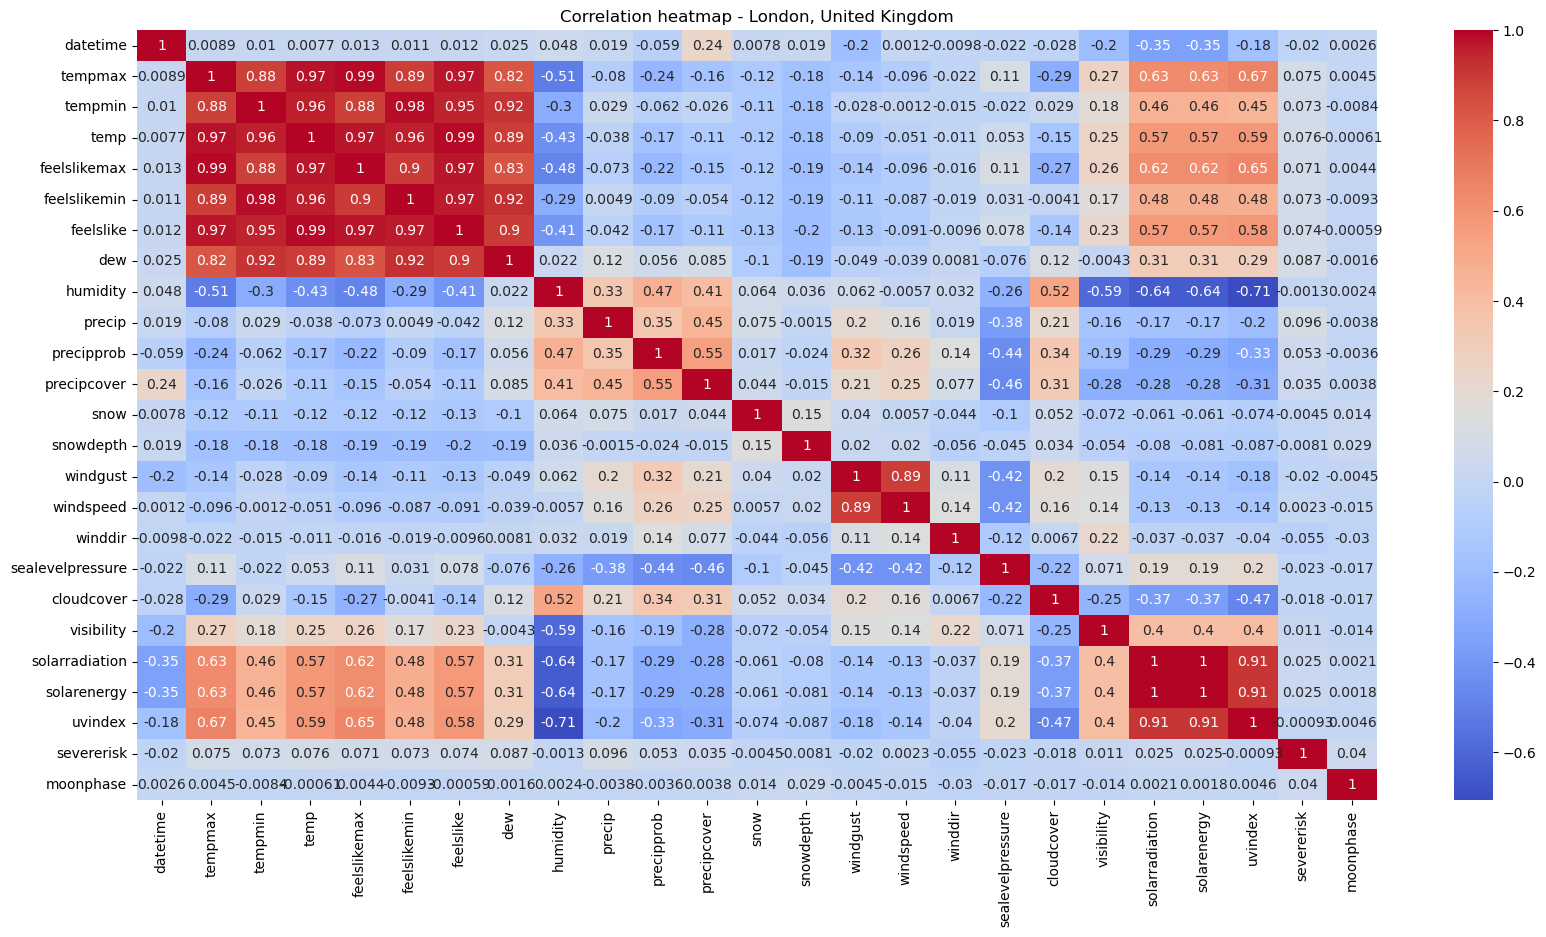

In [243]:
#heatmap

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation heatmap - London, United Kingdom")

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\heatmap.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 


plt.show()

In [244]:
# look into the correlation that humidity has with temp (-0.43) + solarradiation, solarenergy or uvindex
# look into multicolinearity - multiple feature that are roughly the same as the target, which need to be removed (first 5 after the first one)

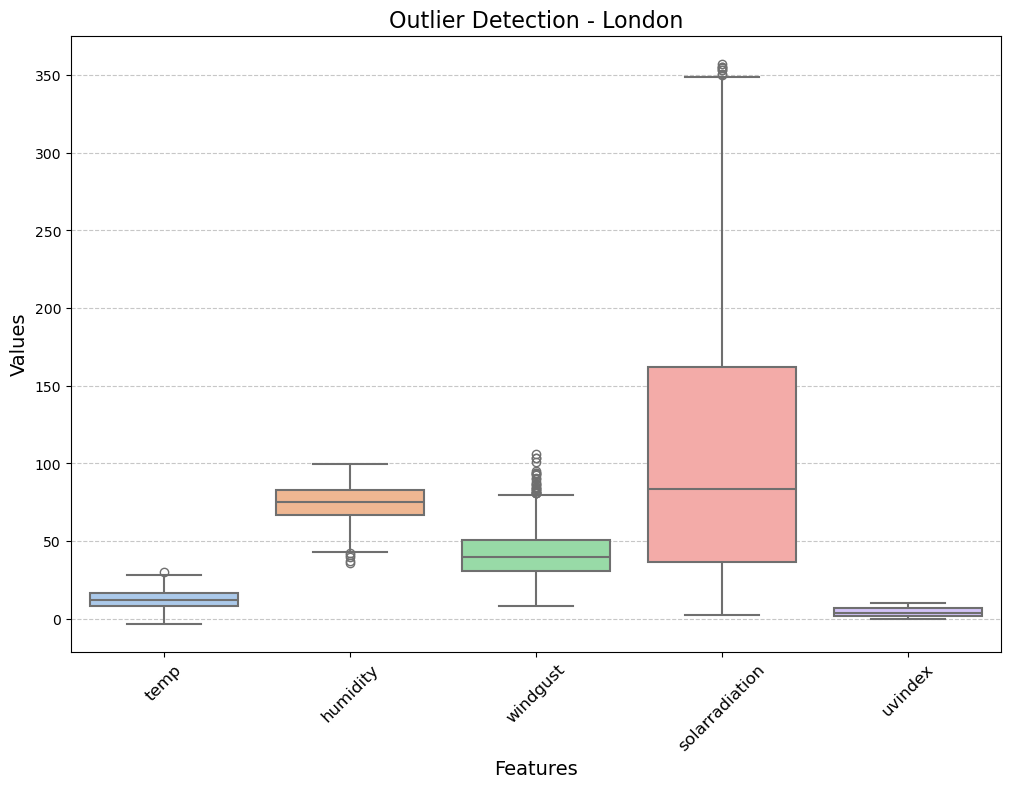

In [245]:
#checking for outliers

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_london[['temp', 'humidity', 'windgust', 'solarradiation', 'uvindex']], 
             palette='pastel', linewidth=1.5)
plt.title("Outlier Detection - London", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\outlier_check.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [246]:
# look into how each of these are measured 
# for example temp is the average at 18 
#first run the models with outliers and then see the results 

In [247]:
df_london.set_index("datetime", inplace = True)
df_london.sort_index(inplace = True)

In [248]:
df_london.head()

name  tempmax  tempmin  temp  \
datetime                                                              
2014-01-01  London, England, United Kingdom     11.6      6.7   9.1   
2014-01-02  London, England, United Kingdom     11.0      6.6   9.1   
2014-01-03  London, England, United Kingdom     10.6      7.3   9.0   
2014-01-04  London, England, United Kingdom     10.1      4.5   8.0   
2014-01-05  London, England, United Kingdom     12.0      1.8   6.0   

            feelslikemax  feelslikemin  feelslike  dew  humidity  precip  \
datetime                                                                   
2014-01-01          11.6           3.6        7.0  6.7      84.8  11.857   
2014-01-02          11.0           3.6        7.2  6.0      81.0   5.394   
2014-01-03          10.6           3.2        6.5  5.1      76.8   6.030   
2014-01-04          10.1           2.0        5.1  5.2      82.4   5.239   
2014-01-05          12.0          -0.9        3.6  3.9      85.9   0.201   

            precipprob  precipcover preciptype  snow  snowdepth  windgust  \
datetime                                                                    
2014-01-01         100        16.67       rain   0.0        0.0      72.4   
2014-01-02         100        12.50       rain   0.0        0.0      51.8   
2014-01-03         100        16.67       rain   0.0        0.0      77.4   
2014-01-04         100        16.67       rain   0.0        0.0      62.1   
2014-01-05         100         8.33       rain   0.0        0.0      55.6   

            windspeed  winddir  sealevelpressure  cloudcover  visibility  \
datetime                                                                   
2014-01-01       38.4    190.5             993.1        67.4        14.2   
2014-01-02       29.8    216.2             993.4        47.4        26.7   
2014-01-03       33.5    218.4             994.5        52.8        17.9   
2014-01-04       29.2    206.0             993.6        67.6        22.0   
2014-01-05       30.4    192.5            1000.0        66.5        25.5   

            solarradiation  solarenergy  uvindex  severerisk  moonphase  \
datetime                                                                  
2014-01-01             6.9          0.5        0         NaN       0.00   
2014-01-02            38.3          3.3        2         NaN       0.03   
2014-01-03            30.3          2.8        2         NaN       0.07   
2014-01-04            17.4          1.4        1         NaN       0.10   
2014-01-05            30.4          2.6        2         NaN       0.14   

                        conditions  \
datetime                             
2014-01-01  Rain, Partially cloudy   
2014-01-02  Rain, Partially cloudy   
2014-01-03  Rain, Partially cloudy   
2014-01-04  Rain, Partially cloudy   
2014-01-05  Rain, Partially cloudy   

                                                  description  icon  \
datetime                                                              
2014-01-01  Partly cloudy throughout the day with a chance...  rain   
2014-01-02        Partly cloudy throughout the day with rain.  rain   
2014-01-03  Partly cloudy throughout the day with a chance...  rain   
2014-01-04  Partly cloudy throughout the day with a chance...  rain   
2014-01-05        Partly cloudy throughout the day with rain.  rain   

                                                     stations  
datetime                                                       
2014-01-01  03769099999,EGWU,03680099999,03768399999,03672...  
2014-01-02  03769099999,03680099999,03672099999,0378109999...  
2014-01-03  03769099999,03680099999,03672099999,0378109999...  
2014-01-04  03769099999,03680099999,03672099999,0378109999...  
2014-01-05  03769099999,03680099999,03672099999,0378109999...

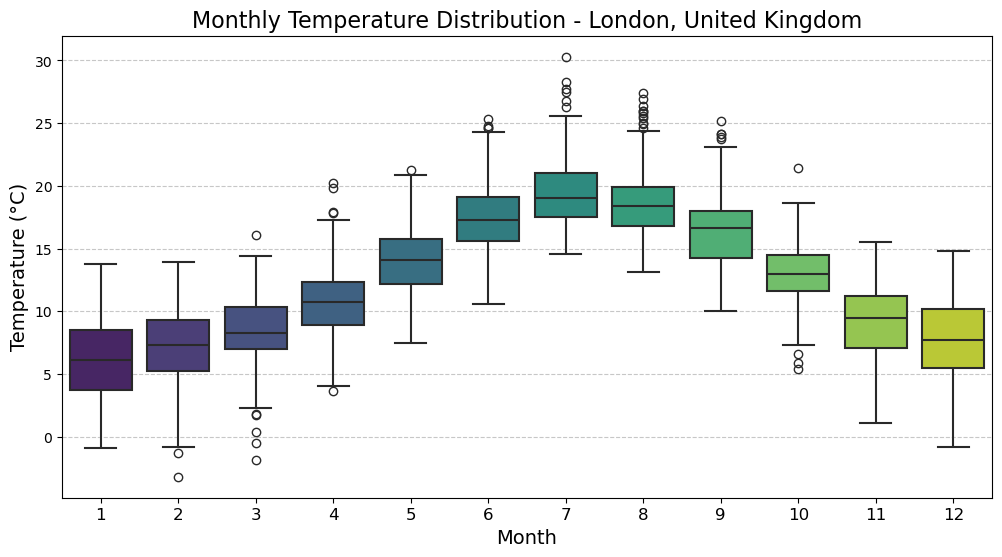

In [249]:
#understanding monthly distribution of the data and how the temperature differ from month to month

df_london['month'] = df_london.index.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='temp', data=df_london, palette='viridis', linewidth=1.5)
plt.title('Monthly Temperature Distribution - London, United Kingdom', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Temperature (¬∞C)', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\targetfeature_distribution.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

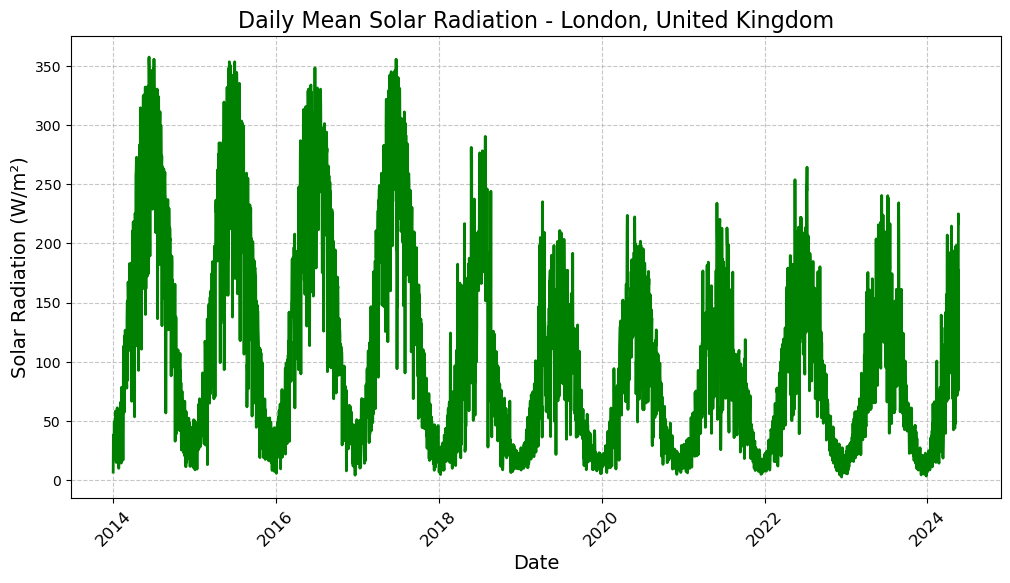

In [250]:
#looking to understand how the mean solar radiation is changing from year to year

daily_solar_radiation = df_london['solarradiation'].resample('D').mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_solar_radiation.index, daily_solar_radiation.values, linestyle='-', color='green', linewidth=2)
plt.title('Daily Mean Solar Radiation - London, United Kingdom', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Solar Radiation (W/m¬≤)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\daily_mean_solarradiation.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300) 

plt.show()

## Missing values

In [251]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust             175
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2931
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [252]:
#run k-nn to fill in the missing values with the k nearest neighbour 
#https://www.sciencedirect.com/science/article/abs/pii/S0164121212001586#:~:text=kNN%20imputation%20is%20designed%20to,or%20attribute)%20is%20categorical%2C%20referred

imputer = KNNImputer(n_neighbors=5)
df_london[['windgust', 'severerisk']] = imputer.fit_transform(df_london[['windgust', 'severerisk']])

In [253]:
df_london['preciptype'].unique()

array(['rain', nan, 'rain,snow', 'snow'], dtype=object)

In [254]:
df_london['preciptype'].value_counts()

preciptype
rain         2320
rain,snow      40
snow            7
Name: count, dtype: int64

In [255]:
df_london.isna().sum()

name                   0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          1426
snow                   0
snowdepth              0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk             0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
month                  0
dtype: int64

In [256]:
#filling in missing values from precipitation because if they are missing, it means there was no registration of precipitation that day
df_london['preciptype'] = df_london['preciptype'].fillna(0)

In [257]:
df_london.isna().sum()

name                0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
preciptype          0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
severerisk          0
moonphase           0
conditions          0
description         0
icon                0
stations            0
month               0
dtype: int64

## Droppping columns

In [258]:
# based on the heatmap, it seems that columns like tempmax, tempin, feelslikemax, feelslikemin and feelslike are too similar with the target variable and they are being dropped as to not create any data leakage in the models to follow

- https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [259]:
columns_to_drop = ['tempmax', 'tempmin', 'icon', 'stations', 'conditions', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'preciptype', 'name']
df_london = df_london.drop(columns=columns_to_drop)

## Tokenization of the "description" column

In [260]:
# adds columns in dataframe to let model know which conditions are most likely in one location

In [261]:
# step 1: text processing
tokenizer = CountVectorizer()
hashingTF = TfidfTransformer(use_idf=False)
idf = TfidfTransformer(use_idf=True)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

In [262]:
# pipeline that processes text and then clusters
pipeline = Pipeline(steps=[
    ('tokenizer', tokenizer),
    ('hashingTF', hashingTF),
    ('idf', idf),
    ('kmeans', kmeans)
])

In [263]:
# fitting the model on the "description"column
text_features = pipeline.fit_transform(df_london['description'])

In [264]:
kmeans.labels_
df_london['clusters_description'] = kmeans.labels_

In [265]:
df_london['clusters_description'].value_counts()

clusters_description
0    2309
1    1244
2     240
Name: count, dtype: int64

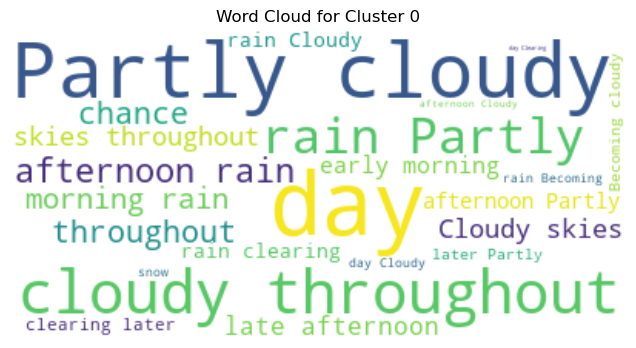

<Figure size 640x480 with 0 Axes>

In [266]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==0]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 0')
plt.show()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_0.png'
plt.savefig(save_path, bbox_inches='tight') 

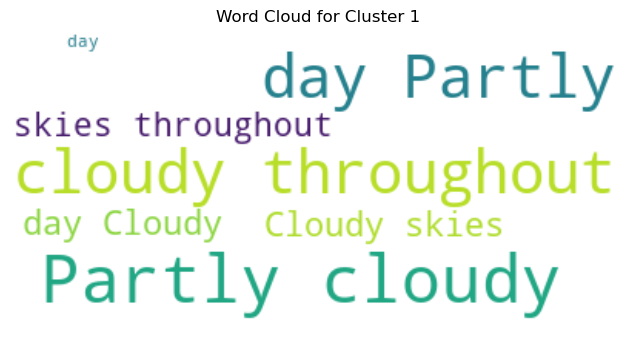

<Figure size 640x480 with 0 Axes>

In [267]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==1]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 1')
plt.show()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_1.png'
plt.savefig(save_path, bbox_inches='tight') 

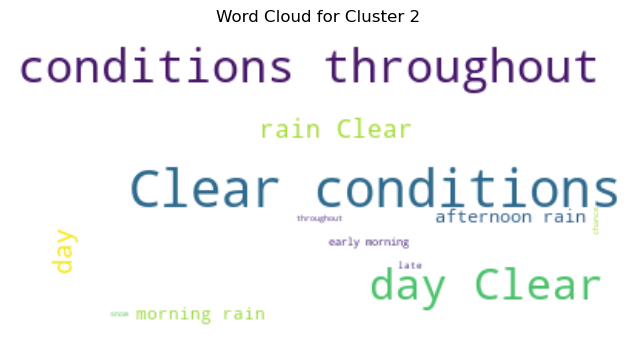

<Figure size 640x480 with 0 Axes>

In [268]:
text = ' '.join(description for description in df_london[df_london['clusters_description']==2]['description'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Cluster 2')
plt.show()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\wordcloud_cluster_2.png'
plt.savefig(save_path, bbox_inches='tight') 

In [269]:
df_london = df_london.drop(columns=['description'])
df_london.head(5)

temp  dew  humidity  precip  precipprob  precipcover  snow  \
datetime                                                                 
2014-01-01   9.1  6.7      84.8  11.857         100        16.67   0.0   
2014-01-02   9.1  6.0      81.0   5.394         100        12.50   0.0   
2014-01-03   9.0  5.1      76.8   6.030         100        16.67   0.0   
2014-01-04   8.0  5.2      82.4   5.239         100        16.67   0.0   
2014-01-05   6.0  3.9      85.9   0.201         100         8.33   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
datetime                                                                
2014-01-01        0.0      72.4       38.4    190.5             993.1   
2014-01-02        0.0      51.8       29.8    216.2             993.4   
2014-01-03        0.0      77.4       33.5    218.4             994.5   
2014-01-04        0.0      62.1       29.2    206.0             993.6   
2014-01-05        0.0      55.6       30.4    192.5            1000.0   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
datetime                                                                   
2014-01-01        67.4        14.2             6.9          0.5        0   
2014-01-02        47.4        26.7            38.3          3.3        2   
2014-01-03        52.8        17.9            30.3          2.8        2   
2014-01-04        67.6        22.0            17.4          1.4        1   
2014-01-05        66.5        25.5            30.4          2.6        2   

            severerisk  moonphase  month  clusters_description  
datetime                                                        
2014-01-01        10.0       0.00      1                     0  
2014-01-02        10.0       0.03      1                     0  
2014-01-03        10.0       0.07      1                     0  
2014-01-04        10.0       0.10      1                     0  
2014-01-05        10.0       0.14      1                     0

## Lagged features

1. Capturing Autocorrelation:
Time series data often exhibit autocorrelation, meaning past values influence future values. Lagged features explicitly capture this relationship by including previous observations as features. For instance, if the target variable at time 
ùë°
t is influenced by its value at time 
ùë°
‚àí
1
t‚àí1, creating a lagged feature for 
ùë°
‚àí
1
t‚àí1 allows the model to recognize this dependency.
2. Modeling Seasonality and Trends:
Time series data can have seasonal patterns or long-term trends. Lagged features at specific intervals (e.g., a lag of 12 months to capture annual seasonality) help the model learn and predict these patterns.
3. Enhancing Predictive Power:
By including past values as features, lagged features enrich the information available to the model. This often leads to more accurate predictions, especially when past behavior strongly influences future outcomes.
4. Capturing Delayed Effects:
Some events or changes might have delayed effects on the target variable. Lagged features allow the model to capture these delays. For example, a marketing campaign might not impact sales immediately but could have a lagged effect over several weeks.
5. Enabling Simple Models to Capture Complex Dynamics:
Even simple models, like linear regression, can capture complex time series dynamics when lagged features are included. For instance, a linear model with appropriately selected lagged features can effectively forecast data that would otherwise require more complex models.
6. Creating Interaction Terms:
Lagged features can interact with other variables, providing additional insights into how past values of the target variable (or other features) influence future outcomes in conjunction with other factors.

In [270]:
#shifting the features by 3 days

In [271]:
# this shifts all features by three days except the temp, and then it merges them back togther
df_london_shifted = df_london.drop('temp', axis=1).shift(3)

In [272]:
df_london_eng = pd.concat([df_london['temp'], df_london_shifted], axis=1)

In [273]:
df_london_eng.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
datetime                                                                 
2014-01-01   9.1  NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-02   9.1  NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-03   9.0  NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-04   8.0  6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0  6.0      81.0   5.394       100.0        12.50   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
datetime                                                                
2014-01-01        NaN       NaN        NaN      NaN               NaN   
2014-01-02        NaN       NaN        NaN      NaN               NaN   
2014-01-03        NaN       NaN        NaN      NaN               NaN   
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
datetime                                                                   
2014-01-01         NaN         NaN             NaN          NaN      NaN   
2014-01-02         NaN         NaN             NaN          NaN      NaN   
2014-01-03         NaN         NaN             NaN          NaN      NaN   
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   

            severerisk  moonphase  month  clusters_description  
datetime                                                        
2014-01-01         NaN        NaN    NaN                   NaN  
2014-01-02         NaN        NaN    NaN                   NaN  
2014-01-03         NaN        NaN    NaN                   NaN  
2014-01-04        10.0       0.00    1.0                   0.0  
2014-01-05        10.0       0.03    1.0                   0.0

In [274]:
df_london_shifted.head()

dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2014-01-01  NaN       NaN     NaN         NaN          NaN   NaN        NaN   
2014-01-02  NaN       NaN     NaN         NaN          NaN   NaN        NaN   
2014-01-03  NaN       NaN     NaN         NaN          NaN   NaN        NaN   
2014-01-04  6.7      84.8  11.857       100.0        16.67   0.0        0.0   
2014-01-05  6.0      81.0   5.394       100.0        12.50   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2014-01-01       NaN        NaN      NaN               NaN         NaN   
2014-01-02       NaN        NaN      NaN               NaN         NaN   
2014-01-03       NaN        NaN      NaN               NaN         NaN   
2014-01-04      72.4       38.4    190.5             993.1        67.4   
2014-01-05      51.8       29.8    216.2             993.4        47.4   

            visibility  solarradiation  solarenergy  uvindex  severerisk  \
datetime                                                                   
2014-01-01         NaN             NaN          NaN      NaN         NaN   
2014-01-02         NaN             NaN          NaN      NaN         NaN   
2014-01-03         NaN             NaN          NaN      NaN         NaN   
2014-01-04        14.2             6.9          0.5      0.0        10.0   
2014-01-05        26.7            38.3          3.3      2.0        10.0   

            moonphase  month  clusters_description  
datetime                                            
2014-01-01        NaN    NaN                   NaN  
2014-01-02        NaN    NaN                   NaN  
2014-01-03        NaN    NaN                   NaN  
2014-01-04       0.00    1.0                   0.0  
2014-01-05       0.03    1.0                   0.0

In [275]:
# adding back the last three rows, which have all the shifted features but without the temp for them as that is what we predict
last_three = df_london_shifted.tail(3)
last_three.set_index( pd.date_range(start=max(df_london.index)+pd.Timedelta(days=1), periods=3, freq='D'))


dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
2024-05-21  10.5      69.7   0.797       100.0         8.33   0.0        0.0   
2024-05-22  12.4      89.1  10.126       100.0        20.83   0.0        0.0   
2024-05-23  10.3      70.2   0.000         0.0         0.00   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
2024-05-21      25.0       15.2    147.1            1004.2        52.3   
2024-05-22      18.4       10.1    213.9            1005.2        58.3   
2024-05-23      17.4        9.4    194.8            1009.3        41.4   

            visibility  solarradiation  solarenergy  uvindex  severerisk  \
2024-05-21        19.4           118.8         10.3      9.0        10.0   
2024-05-22        15.8            74.5          6.5      3.0        10.0   
2024-05-23        21.7           177.8         15.5     10.0        10.0   

            moonphase  month  clusters_description  
2024-05-21       0.25    5.0                   0.0  
2024-05-22       0.27    5.0                   0.0  
2024-05-23       0.30    5.0                   1.0

In [276]:
max(df_london.index)+pd.Timedelta(days=1)

Timestamp('2024-05-21 00:00:00')

In [277]:
df_london_final = pd.concat([df_london_eng, last_three], ignore_index=True)

In [278]:
df_london_final = df_london_final.set_index(pd.date_range(start=min(df_london.index), periods=len(df_london)+3, freq='D'))

In [279]:
df_london_final.tail()

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   
2024-05-21   NaN  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-22   NaN  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-23   NaN  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   
2024-05-21        0.0      25.0       15.2    147.1            1004.2   
2024-05-22        0.0      18.4       10.1    213.9            1005.2   
2024-05-23        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   
2024-05-21        52.3        19.4           118.8         10.3      9.0   
2024-05-22        58.3        15.8            74.5          6.5      3.0   
2024-05-23        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  month  clusters_description  
2024-05-19        10.0       0.27    5.0                   0.0  
2024-05-20        10.0       0.30    5.0                   1.0  
2024-05-21        10.0       0.25    5.0                   0.0  
2024-05-22        10.0       0.27    5.0                   0.0  
2024-05-23        10.0       0.30    5.0                   1.0

In [280]:
# I created three new dates with all the lagged features aside from temp, which will be predicted in the next section

## Train and test split 

In [281]:
# done based on the date as it's a time series

In [282]:
# because XGBoost is not a time series model (address it as a limitation), i will split the datetime column into days, months and year, so the model can learn which temperature is related to the May month and which temperature is related to the December month, as it learns accross multiple years

In [283]:
df_london_final['month'] = df_london_final.index.month
df_london_final['year'] = df_london_final.index.year

In [284]:
df_dummies = pd.get_dummies(df_london_final['month'], prefix='month')

In [285]:
df_london_final = pd.concat([df_london_final, df_dummies], axis=1)
df_london_final.drop(columns=['month'], inplace=True)

In [286]:
df_london_final.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2014-01-01   9.1  NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-02   9.1  NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-03   9.0  NaN       NaN     NaN         NaN          NaN   NaN   
2014-01-04   8.0  6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0  6.0      81.0   5.394       100.0        12.50   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2014-01-01        NaN       NaN        NaN      NaN               NaN   
2014-01-02        NaN       NaN        NaN      NaN               NaN   
2014-01-03        NaN       NaN        NaN      NaN               NaN   
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2014-01-01         NaN         NaN             NaN          NaN      NaN   
2014-01-02         NaN         NaN             NaN          NaN      NaN   
2014-01-03         NaN         NaN             NaN          NaN      NaN   
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2014-01-01         NaN        NaN                   NaN  2014     True   
2014-01-02         NaN        NaN                   NaN  2014     True   
2014-01-03         NaN        NaN                   NaN  2014     True   
2014-01-04        10.0       0.00                   0.0  2014     True   
2014-01-05        10.0       0.03                   0.0  2014     True   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2014-01-01    False    False    False    False    False    False    False   
2014-01-02    False    False    False    False    False    False    False   
2014-01-03    False    False    False    False    False    False    False   
2014-01-04    False    False    False    False    False    False    False   
2014-01-05    False    False    False    False    False    False    False   

            month_9  month_10  month_11  month_12  
2014-01-01    False     False     False     False  
2014-01-02    False     False     False     False  
2014-01-03    False     False     False     False  
2014-01-04    False     False     False     False  
2014-01-05    False     False     False     False

In [287]:
df_train = df_london_final.iloc[:-368] #training set - takes the last 368 days
df_test = df_london_final.iloc[-368:-3] #test set - takes the last 368 - the last 3 days for preds
df_future =  df_london_final.iloc[-3:] #future dataframe that contains the predictions that we will generate but right now jas just the features

In [288]:
df_train.head()
df_train.dropna(inplace=True)

## 1. XGBOOST 

### 1.1 Baseline model

In [289]:
start_time = time.time()
model_baseline = XGBRegressor()
model_baseline.fit(df_train.drop('temp',axis=1), df_train[['temp']])
end_time = time.time()

#calculates the time taken for each model to compute
time_xgboost_baseline = end_time - start_time
print(f"Model execution time for XGBoost baseline: {time_xgboost_baseline:.4f} seconds")

Model execution time for XGBoost baseline: 0.5967 seconds


In [290]:
y_pred_xgboost = model_baseline.predict(df_test.drop('temp',axis=1))

In [291]:
y_pred_xgboost

array([14.492051 , 17.870735 , 16.441523 , 14.017682 , 13.3807955,
       18.364727 , 13.875509 , 16.55626  , 13.40738  , 17.022013 ,
       13.096956 , 15.220464 , 18.718847 , 16.462023 , 17.883986 ,
       18.190876 , 18.983713 , 15.292368 , 13.434772 , 16.804014 ,
       17.765388 , 17.663021 , 17.780577 , 18.162876 , 19.35969  ,
       16.947762 , 18.929035 , 15.666152 , 18.354177 , 16.387234 ,
       18.575077 , 16.272154 , 17.615025 , 20.331121 , 17.903595 ,
       20.021744 , 19.140293 , 18.134293 , 19.111702 , 21.45441  ,
       19.583147 , 20.168015 , 18.224314 , 18.75007  , 18.87896  ,
       17.913774 , 16.178864 , 18.172672 , 20.501274 , 21.236399 ,
       20.726442 , 20.156572 , 17.11704  , 16.378408 , 17.71087  ,
       18.798628 , 16.771502 , 17.329672 , 16.65339  , 17.572655 ,
       19.383886 , 20.404385 , 20.10089  , 18.238998 , 17.524273 ,
       17.880363 , 16.556747 , 16.61994  , 17.54138  , 18.602844 ,
       16.800179 , 17.26145  , 17.58127  , 16.794807 , 18.3065

In [292]:
has_na = np.isnan(y_pred_xgboost).any()
print({has_na})

{False}


In [293]:
na_count = np.isnan(y_pred_xgboost).sum()
print({na_count})

{0}


In [294]:
df_test.isna()

temp    dew  humidity  precip  precipprob  precipcover   snow  \
2023-05-22  False  False     False   False       False        False  False   
2023-05-23  False  False     False   False       False        False  False   
2023-05-24  False  False     False   False       False        False  False   
2023-05-25  False  False     False   False       False        False  False   
2023-05-26  False  False     False   False       False        False  False   
...           ...    ...       ...     ...         ...          ...    ...   
2024-05-16  False  False     False   False       False        False  False   
2024-05-17  False  False     False   False       False        False  False   
2024-05-18  False  False     False   False       False        False  False   
2024-05-19  False  False     False   False       False        False  False   
2024-05-20  False  False     False   False       False        False  False   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22      False     False      False    False             False   
2023-05-23      False     False      False    False             False   
2023-05-24      False     False      False    False             False   
2023-05-25      False     False      False    False             False   
2023-05-26      False     False      False    False             False   
...               ...       ...        ...      ...               ...   
2024-05-16      False     False      False    False             False   
2024-05-17      False     False      False    False             False   
2024-05-18      False     False      False    False             False   
2024-05-19      False     False      False    False             False   
2024-05-20      False     False      False    False             False   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22       False       False           False        False    False   
2023-05-23       False       False           False        False    False   
2023-05-24       False       False           False        False    False   
2023-05-25       False       False           False        False    False   
2023-05-26       False       False           False        False    False   
...                ...         ...             ...          ...      ...   
2024-05-16       False       False           False        False    False   
2024-05-17       False       False           False        False    False   
2024-05-18       False       False           False        False    False   
2024-05-19       False       False           False        False    False   
2024-05-20       False       False           False        False    False   

            severerisk  moonphase  clusters_description   year  month_1  \
2023-05-22       False      False                 False  False    False   
2023-05-23       False      False                 False  False    False   
2023-05-24       False      False                 False  False    False   
2023-05-25       False      False                 False  False    False   
2023-05-26       False      False                 False  False    False   
...                ...        ...                   ...    ...      ...   
2024-05-16       False      False                 False  False    False   
2024-05-17       False      False                 False  False    False   
2024-05-18       False      False                 False  False    False   
2024-05-19       False      False                 False  False    False   
2024-05-20       False      False                 False  False    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False    False    False    False    False   
2023-05-23    False    False    False    False    False    False    False   
2023-05-24    False    False    False    False    False    False    False   
2023-05-25    False    False    False    False    False    False    False   


### 1.2 Performance metrics for XGBOOST baseline

In [295]:
mae = mean_absolute_error(df_test['temp'], y_pred_xgboost)
mse = mean_squared_error(df_test['temp'], y_pred_xgboost)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_xgboost)

print(f"Mean Absolute Error (MAE) for XGBoost baseline with all regressors: {mae}")
print(f"Mean Squared Error (MSE) for XGBoost baseline with all regressors: {mse}")
print(f"Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: {rmse}")
print(f"R-squared (R2) for XGBoost baseline with all regressors: {r2}")

Mean Absolute Error (MAE) for XGBoost baseline with all regressors: 2.3868065674664227
Mean Squared Error (MSE) for XGBoost baseline with all regressors: 8.827414221743139
Root Mean Squared Error (RMSE) for XGBoost baseline with all regressors: 2.971096467929498
R-squared (R2) for XGBoost baseline with all regressors: 0.6797312280993014


In [296]:
# for RMSE: if my prediction is errored I want that to inflate the error - but don't know in which direction
# MAE: it means it's 2.3 degrees away from truth just don't know in which direction 

### 1.3 XGBOOST baseline predictions vs actuals

In [297]:
df_test[['temp']]

temp
2023-05-22  15.1
2023-05-23  14.0
2023-05-24  15.8
2023-05-25  15.0
2023-05-26  14.2
...          ...
2024-05-16  14.2
2024-05-17  16.4
2024-05-18  15.8
2024-05-19  16.6
2024-05-20  15.1

[365 rows x 1 columns]

In [298]:
df_test_w_preds = df_test.copy()

In [299]:
#create new column in order to attach index date to the preds
df_test_w_preds['preds'] = y_pred_xgboost

In [300]:
def plot_forecast(actuals, predictions, model_name, save_path=None):
    plt.figure(figsize=(15, 10))

    plt.plot(actuals, label='Actuals', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2)
    plt.plot(predictions, label='Predictions', color='orange', marker='s', markersize=5, linestyle='-', linewidth=2)

    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Temperature', fontsize=14)
    plt.title(f'Predicted vs Actual Temperature - {model_name}', fontsize=16)

    plt.grid(True)
    plt.legend(fontsize=12)

    if save_path is not None:
        plt.savefig(f"{save_path}/{model_name}_predictions.png", bbox_inches='tight', dpi=300)

    plt.show()

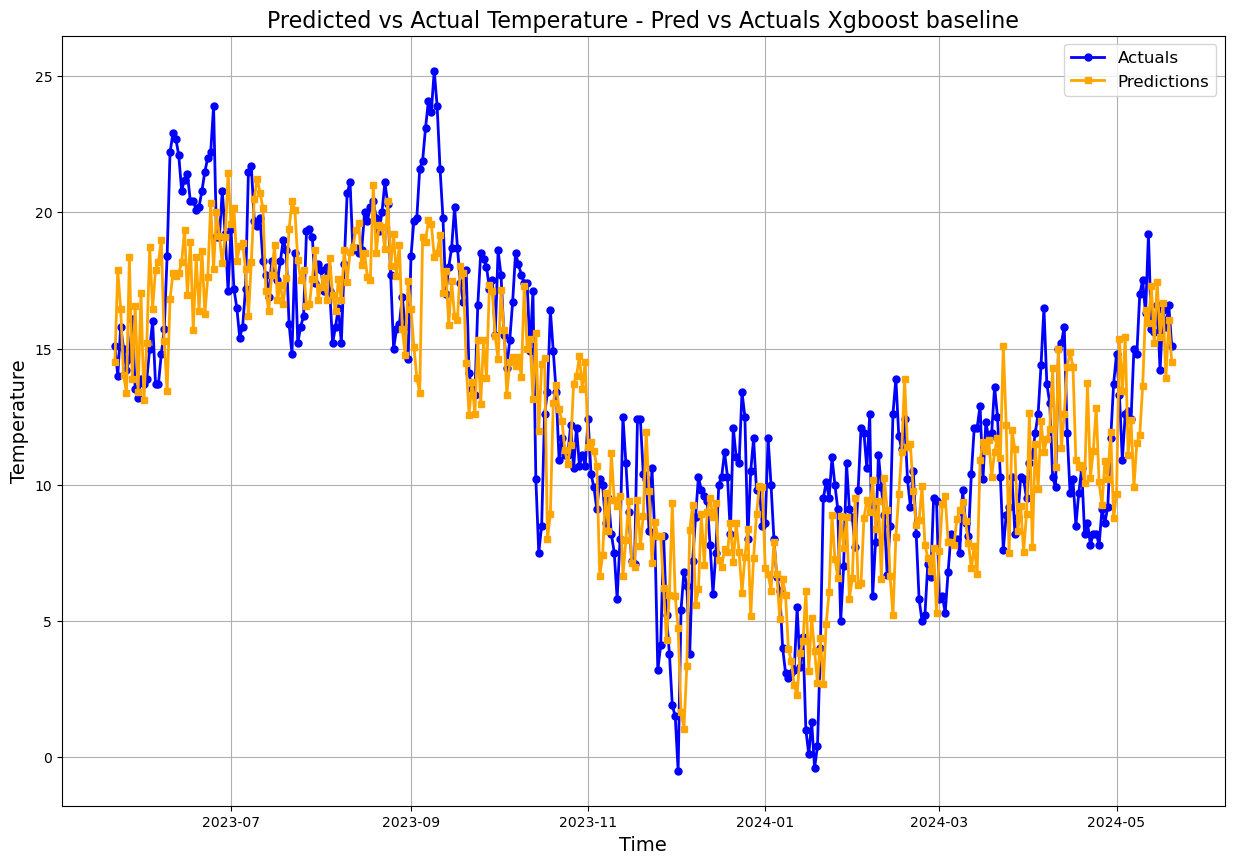

In [301]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds']], 'Pred vs Actuals Xgboost baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 1.4 Feature importance

<Figure size 1200x800 with 0 Axes>

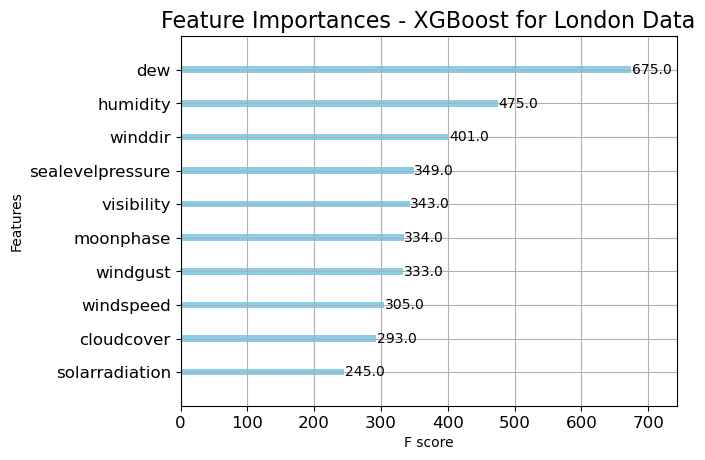

In [303]:
plt.figure(figsize=(12, 8))
plot_importance(model_baseline, 
                importance_type='weight', 
                max_num_features=10, 
                title='Feature Importances - XGBoost for London Data', 
                xlabel='F score', 
                ylabel='Features', 
                grid=True,
                color='skyblue')

plt.title('Feature Importances - XGBoost for London Data', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\feature_importance.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

In [77]:
# look into dew and the importance of it in terms of climate change and weather prediction 
# the year has quite an important impact as it shows that the average temp is changing every year and therefore has an impact on all predictions
# it proves the temperature changes every year, and it is not cyclical 
# try removing all below 30 

In [78]:
future_preds = model_baseline.predict(df_future.drop('temp', axis=1))

In [79]:
df_future['preds'] = future_preds

In [80]:
df_future

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2024-05-21   NaN  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-22   NaN  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-23   NaN  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2024-05-21        0.0      25.0       15.2    147.1            1004.2   
2024-05-22        0.0      18.4       10.1    213.9            1005.2   
2024-05-23        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2024-05-21        52.3        19.4           118.8         10.3      9.0   
2024-05-22        58.3        15.8            74.5          6.5      3.0   
2024-05-23        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2024-05-21        10.0       0.25                   0.0  2024    False   
2024-05-22        10.0       0.27                   0.0  2024    False   
2024-05-23        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2024-05-21    False    False    False     True    False    False    False   
2024-05-22    False    False    False     True    False    False    False   
2024-05-23    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds  
2024-05-21    False     False     False     False  13.906611  
2024-05-22    False     False     False     False  16.043221  
2024-05-23    False     False     False     False  14.519270

### 1.5 XGBOOST GS

In [81]:
df_train.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2014-01-04   8.0  6.7      84.8  11.857       100.0        16.67   0.0   
2014-01-05   6.0  6.0      81.0   5.394       100.0        12.50   0.0   
2014-01-06  11.6  5.1      76.8   6.030       100.0        16.67   0.0   
2014-01-07  10.7  5.2      82.4   5.239       100.0        16.67   0.0   
2014-01-08   9.6  3.9      85.9   0.201       100.0         8.33   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2014-01-04        0.0      72.4       38.4    190.5             993.1   
2014-01-05        0.0      51.8       29.8    216.2             993.4   
2014-01-06        0.0      77.4       33.5    218.4             994.5   
2014-01-07        0.0      62.1       29.2    206.0             993.6   
2014-01-08        0.0      55.6       30.4    192.5            1000.0   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2014-01-04        67.4        14.2             6.9          0.5      0.0   
2014-01-05        47.4        26.7            38.3          3.3      2.0   
2014-01-06        52.8        17.9            30.3          2.8      2.0   
2014-01-07        67.6        22.0            17.4          1.4      1.0   
2014-01-08        66.5        25.5            30.4          2.6      2.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2014-01-04        10.0       0.00                   0.0  2014     True   
2014-01-05        10.0       0.03                   0.0  2014     True   
2014-01-06        10.0       0.07                   0.0  2014     True   
2014-01-07        10.0       0.10                   0.0  2014     True   
2014-01-08        10.0       0.14                   0.0  2014     True   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2014-01-04    False    False    False    False    False    False    False   
2014-01-05    False    False    False    False    False    False    False   
2014-01-06    False    False    False    False    False    False    False   
2014-01-07    False    False    False    False    False    False    False   
2014-01-08    False    False    False    False    False    False    False   

            month_9  month_10  month_11  month_12  
2014-01-04    False     False     False     False  
2014-01-05    False     False     False     False  
2014-01-06    False     False     False     False  
2014-01-07    False     False     False     False  
2014-01-08    False     False     False     False

In [82]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'max_leaf_nodes':  [0, 10, 20], 
    'reg_lambda': [0, 0.1, 1]
}

grid_search = GridSearchCV(estimator=model_baseline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [83]:
start_time = time.time()
grid_search.fit(df_train.drop('temp', axis=1), df_train['temp']) #first one is train without target, second one is just target

best_params = grid_search.best_params_
best_score = grid_search.best_score_
end_time = time.time()


time_xgboost_gs = end_time - start_time
print(f"Model execution time for XGBoost grid search: {time_xgboost_gs:.4f} seconds")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Model execution time for XGBoost grid search: 71.3556 seconds


In [84]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 0, 'reg_lambda': 1, 'subsample': 0.7}
Best score: -7.226425704507559


In [85]:
gs_model = XGBRegressor(learning_rate= 0.1, max_depth= 3, subsample= 0.7, max_leaf_nodes=0, reg_lambda=1)
gs_model.fit(df_train.drop('temp',axis=1), df_train[['temp']])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaf_nodes=0,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [86]:
y_pred_xgboost_gs = gs_model.predict(df_test.drop('temp',axis=1))

### 1.6 XGBOOST GS performance metrics

In [87]:
mae = mean_absolute_error(df_test['temp'], y_pred_xgboost_gs)
mse = mean_squared_error(df_test['temp'], y_pred_xgboost_gs)
rmse = mse ** 0.5
r2 = r2_score(df_test['temp'], y_pred_xgboost_gs)

print(f"Mean Absolute Error (MAE) for GS model: {mae}")
print(f"Mean Squared Error (MSE) for GS model: {mse}")
print(f"Root Mean Squared Error (RMSE) for GS model: {rmse}")
print(f"R-squared (R2) for XGBoost baseline GS model: {r2}")

Mean Absolute Error (MAE) for GS model: 2.1030320937012976
Mean Squared Error (MSE) for GS model: 7.130397327265726
Root Mean Squared Error (RMSE) for GS model: 2.6702803836424605
R-squared (R2) for XGBoost baseline GS model: 0.7413009588309011


In [88]:
df_test_w_preds['preds_gs'] = y_pred_xgboost_gs

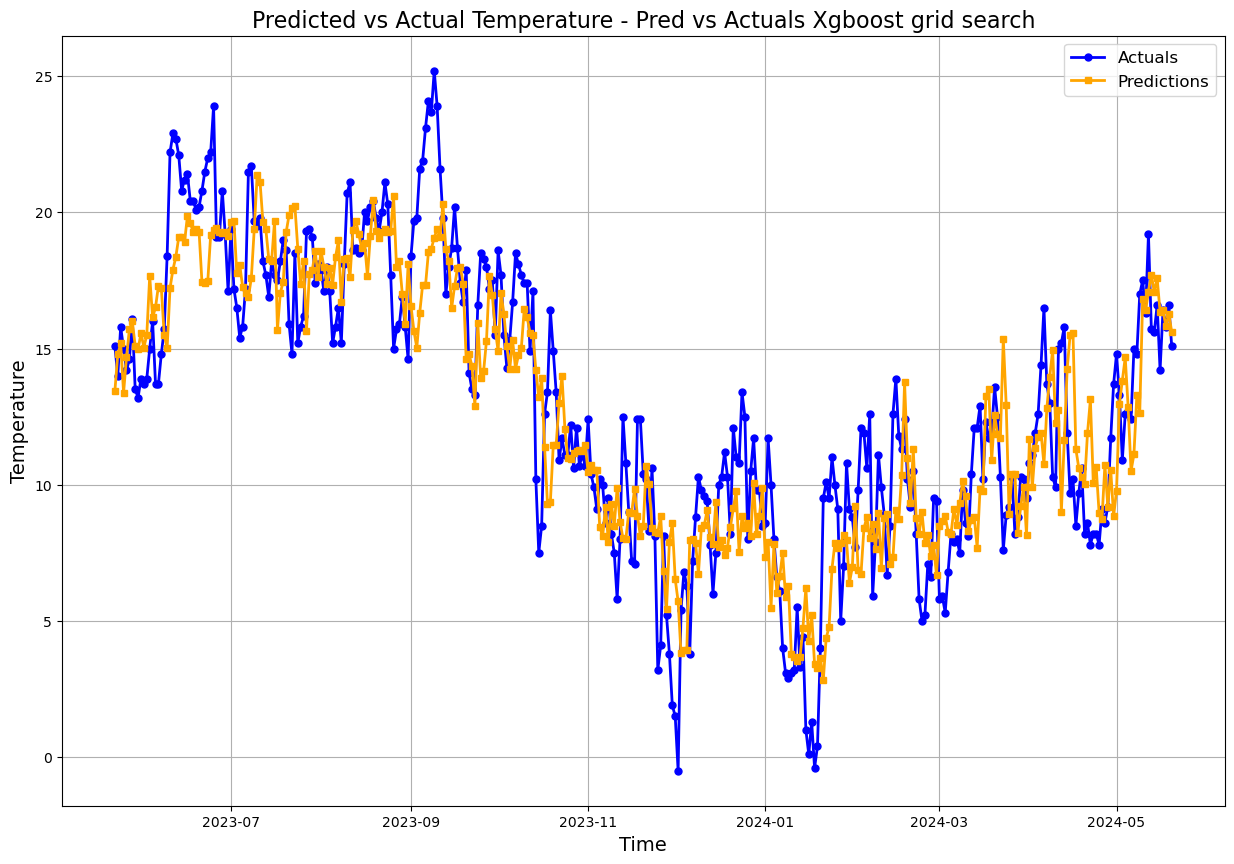

In [218]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_gs']], 'Pred vs Actuals Xgboost grid search', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

## 2. Naive Forecaster (Sktime)

### 2.1 Baseline model

https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html

In [91]:
start_time = time.time()

forecaster_baseline = NaiveForecaster(strategy="mean")
forecaster_baseline.fit(df_train['temp'])

end_time = time.time()
time_naive_baseline = end_time - start_time
print(f"Model execution time for Naive Forecaster baseline: {time_naive_baseline:.4f} seconds")

Model execution time for Naive Forecaster baseline: 0.0040 seconds


In [92]:
y_pred_naiveforecaster = forecaster_baseline.predict(df_test.index)

In [93]:
y_pred_naiveforecaster

2023-05-22    12.189839
2023-05-23    12.189839
2023-05-24    12.189839
2023-05-25    12.189839
2023-05-26    12.189839
                ...    
2024-05-16    12.189839
2024-05-17    12.189839
2024-05-18    12.189839
2024-05-19    12.189839
2024-05-20    12.189839
Freq: D, Name: temp, Length: 365, dtype: float64

In [94]:
df_test_w_preds['sktime_naive'] = y_pred_naiveforecaster

In [95]:
df_test_w_preds.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1  6.9      64.3     0.0         0.0          0.0   0.0   
2023-05-23  14.0  6.1      60.6     0.0         0.0          0.0   0.0   
2023-05-24  15.8  6.7      61.2     0.0         0.0          0.0   0.0   
2023-05-25  15.0  6.7      57.9     0.0         0.0          0.0   0.0   
2023-05-26  14.2  6.9      63.5     0.0         0.0          0.0   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds   preds_gs  \
2023-05-22    False     False     False     False  14.492051  13.432552   
2023-05-23    False     False     False     False  17.870735  14.786562   
2023-05-24    False     False     False     False  16.441523  15.185232   
2023-05-25    False     False     False     False  14.017682  13.373943   
2023-05-26    False     False     False     False  13.380795  14.683416   

            sktime_naive  
2023-05-22     12.189839  
2023-05-23     12.189839  
2023-05-24     12.189839  
2023-05-25     12.189839  
2023-05-26     12.189839

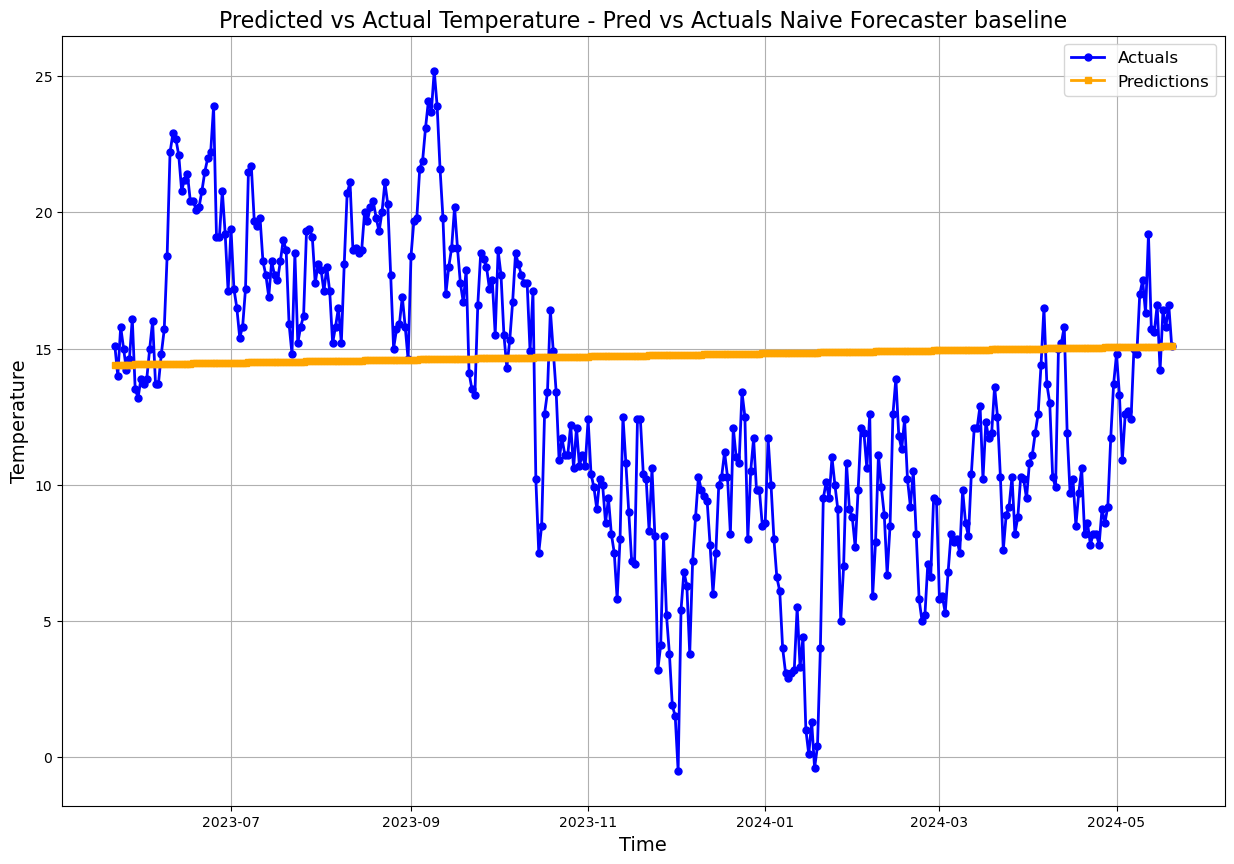

In [219]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['sktime_naive']], 'Pred vs Actuals Naive Forecaster baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 2.2 Naive Forecaster performance metrics

In [97]:
mae = mean_absolute_error(df_test['temp'], y_pred_naiveforecaster)
mse = mean_squared_error(df_test['temp'], y_pred_naiveforecaster)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], y_pred_naiveforecaster)

print(f"Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
print(f"Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
print(f"Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
print(f"R-squared (R¬≤) for the Naive Forecaster: {r2}")

Mean Absolute Error (MAE) for the Naive Forecaster: 4.4214064993500655
Mean Squared Error (MSE) for the Naive Forecaster: 28.21710502528725
Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.311977506097635
R-squared (R¬≤) for the Naive Forecaster: -0.023749123586186638


### 2.3 Naive Forecaster GS

In [98]:
# only one parameter to tune - strategy

In [99]:
def tune_naive(strategy): 
    start_time = time.time()
    forecaster_baseline = NaiveForecaster(strategy=strategy)
    forecaster_baseline.fit(df_train['temp'])
    y_pred_naiveforecaster_gs = forecaster_baseline.predict(df_test.index)
    df_test_w_preds['sktime_naive'] = y_pred_naiveforecaster_gs
    mae = mean_absolute_error(df_test['temp'], y_pred_naiveforecaster_gs)

    mse = mean_squared_error(df_test['temp'], y_pred_naiveforecaster_gs)
    rmse = np.sqrt(mse)
    r2 = r2_score(df_test['temp'], y_pred_naiveforecaster_gs)

    print(f"{strategy}, Mean Absolute Error (MAE) for the Naive Forecaster: {mae}")
    print(f"{strategy}, Mean Squared Error (MSE) for the Naive Forecaster: {mse}")
    print(f"{strategy}, Root Mean Squared Error (RMSE) for the Naive Forecaster: {rmse}")
    print(f"{strategy}, R-squared (R¬≤) for the Naive Forecaster: {r2}")
    end_time = time.time()
    time_naive_gs = end_time - start_time
    print(f"Model execution time: {time_naive_gs:.4f} seconds")

### 2.4. Naive Forecaster GS performance metrics

In [100]:
tune_naive("mean")

mean, Mean Absolute Error (MAE) for the Naive Forecaster: 4.4214064993500655
mean, Mean Squared Error (MSE) for the Naive Forecaster: 28.21710502528725
mean, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.311977506097635
mean, R-squared (R¬≤) for the Naive Forecaster: -0.023749123586186638
Model execution time: 0.0260 seconds


In [101]:
tune_naive("last")

last, Mean Absolute Error (MAE) for the Naive Forecaster: 4.561643835616438
last, Mean Squared Error (MSE) for the Naive Forecaster: 29.52558904109589
last, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.433745397154333
last, R-squared (R¬≤) for the Naive Forecaster: -0.07122243324038968
Model execution time: 0.0373 seconds


In [102]:
tune_naive("drift")

drift, Mean Absolute Error (MAE) for the Naive Forecaster: 4.736848034822686
drift, Mean Squared Error (MSE) for the Naive Forecaster: 31.844905375476948
drift, Root Mean Squared Error (RMSE) for the Naive Forecaster: 5.643129041186011
drift, R-squared (R¬≤) for the Naive Forecaster: -0.15536990558079733
Model execution time: 0.0270 seconds


## 3. AUTO ARIMA

In [103]:
df_train_short = df_train[df_train.index > pd.to_datetime('2021-01-01')]

In [104]:
start_time = time.time()

forecaster_arima = AutoARIMA(sp=12, suppress_warnings=True)
forecaster_arima.fit(df_train_short['temp'])

end_time = time.time()
time_autoarima_baseline = end_time - start_time
print(f"Model execution time for Auto ARIMA: {time_autoarima_baseline:.4f} seconds")

Model execution time for Auto ARIMA: 83.1551 seconds


In [105]:
y_pred_autoarima = forecaster_arima.predict(df_test.index)

In [106]:
y_pred_autoarima

2023-05-22    13.984044
2023-05-23    13.895126
2023-05-24    13.759057
2023-05-25    13.725513
2023-05-26    13.632718
                ...    
2024-05-16    13.488740
2024-05-17    13.489218
2024-05-18    13.488746
2024-05-19    13.489213
2024-05-20    13.488752
Freq: D, Name: temp, Length: 365, dtype: float64

In [107]:
df_test_w_preds['preds_autoarima'] = y_pred_autoarima
df_test_w_preds

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1   6.9      64.3   0.000         0.0         0.00   0.0   
2023-05-23  14.0   6.1      60.6   0.000         0.0         0.00   0.0   
2023-05-24  15.8   6.7      61.2   0.000         0.0         0.00   0.0   
2023-05-25  15.0   6.7      57.9   0.000         0.0         0.00   0.0   
2023-05-26  14.2   6.9      63.5   0.000         0.0         0.00   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   
...                ...         ...             ...          ...      ...   
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   
...                ...        ...                   ...   ...      ...   
2024-05-16        10.0       0.17                   1.0  2024    False   
2024-05-17        10.0       0.20                   0.0  2024    False   
2024-05-18        10.0       0.25                   0.0  2024    False   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True 

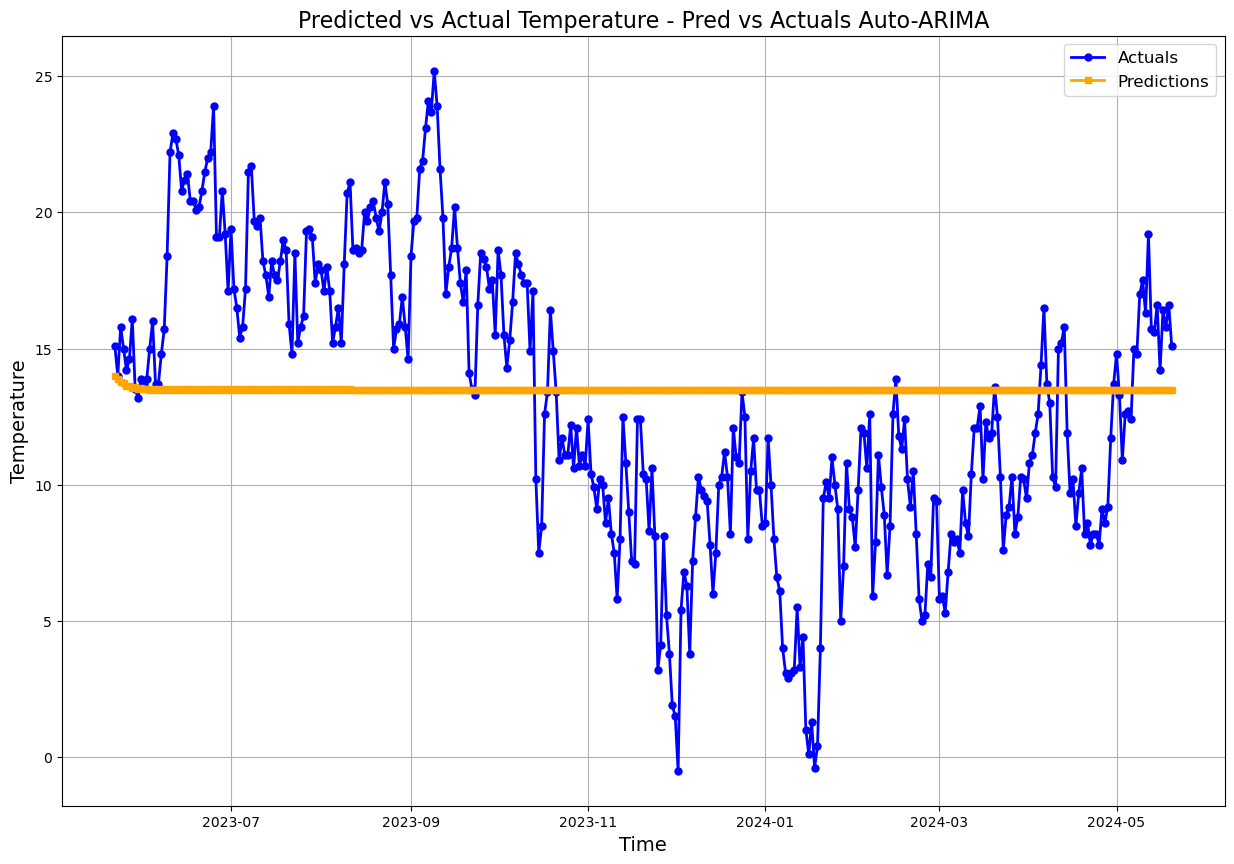

In [220]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_autoarima']], 'Pred vs Actuals Auto-ARIMA', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 3.1 AUTO ARIMA performance metrics

In [109]:
mae = mean_absolute_error(df_test['temp'],y_pred_autoarima)
mse = mean_squared_error(df_test['temp'],y_pred_autoarima)
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], y_pred_autoarima)

print(f"Mean Absolute Error (MAE) for AUTO-ARIMA: {mae}")
print(f"Mean Squared Error (MSE) for AUTO-ARIMA: {mse}")
print(f"Root Mean Squared Error (RMSE) for AUTO-ARIMA: {rmse}")
print(f"R-squared (R¬≤) for AUTO-ARIMA: {r2}") 

Mean Absolute Error (MAE) for AUTO-ARIMA: 4.44099364415425
Mean Squared Error (MSE) for AUTO-ARIMA: 27.790480289674576
Root Mean Squared Error (RMSE) for AUTO-ARIMA: 5.27166769530047
R-squared (R¬≤) for AUTO-ARIMA: -0.008270685993376992


## 4. SARIMAX with all features (Sktime)

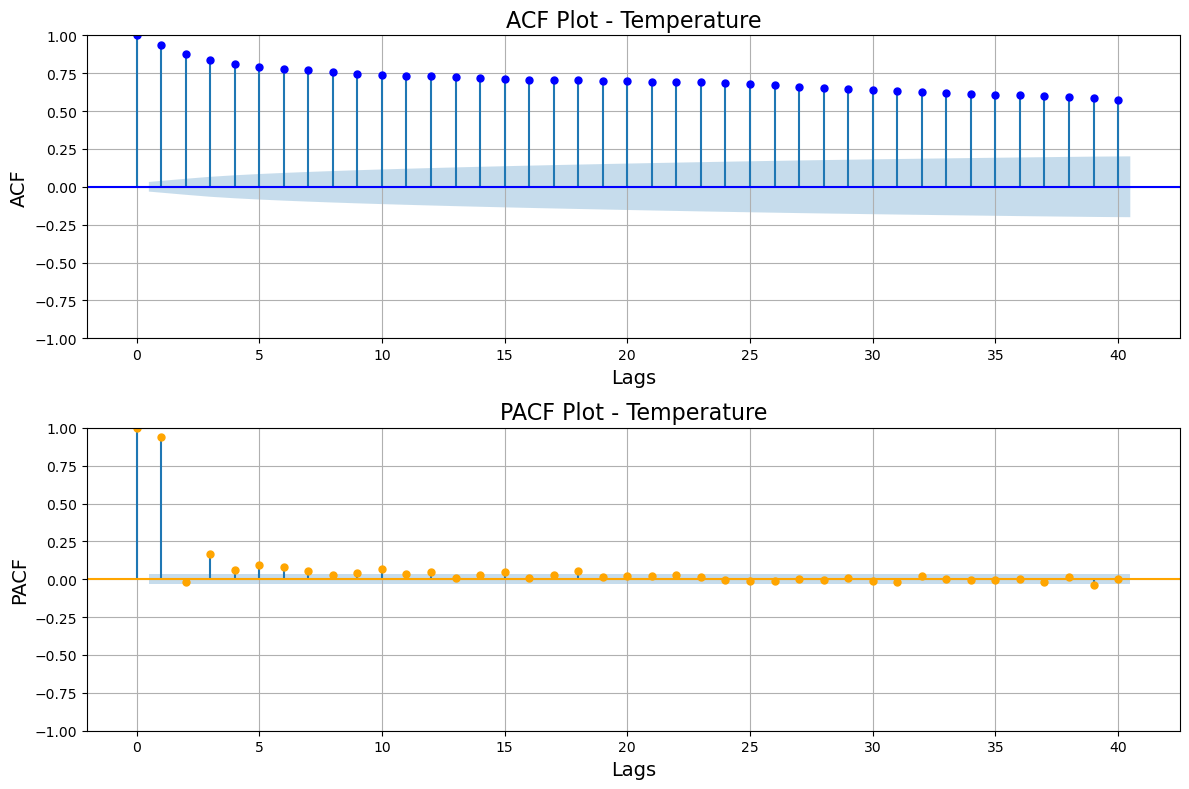

In [304]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df_london['temp'], lags=40, ax=ax[0], color='blue', title='ACF Plot', alpha=0.05)
ax[0].set_title('ACF Plot - Temperature', fontsize=16)
ax[0].set_xlabel('Lags', fontsize=14)
ax[0].set_ylabel('ACF', fontsize=14)
ax[0].grid(True)

# PACF Plot
plot_pacf(df_london['temp'], lags=40, ax=ax[1], color='orange', title='PACF Plot', alpha=0.05)
ax[1].set_title('PACF Plot - Temperature', fontsize=16)
ax[1].set_xlabel('Lags', fontsize=14)
ax[1].set_ylabel('PACF', fontsize=14)
ax[1].grid(True)

plt.tight_layout()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\ACF_PACF.png'
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()

### 4.1 Baseline model 

In [111]:
start_time = time.time()
model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(1, 1, 1),  
    seasonal_order=(1, 1, 1, 12)  
)

In [112]:
sarimax_base_results = model_sarimax_baseline.fit()

end_time = time.time()
time_sarimax_baseline = end_time - start_time
print(f"Model execution time for SARIMAX baseline: {time_sarimax_baseline:.4f} seconds")

Model execution time for SARIMAX baseline: 28.6770 seconds


In [113]:
forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))

In [114]:
forecast_sarimax.predicted_mean

2023-05-22    15.701231
2023-05-23    15.439488
2023-05-24    16.274314
2023-05-25    16.052129
2023-05-26    14.740708
                ...    
2024-05-16    60.305122
2024-05-17    60.777181
2024-05-18    60.639595
2024-05-19    60.068235
2024-05-20    59.786849
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [115]:
df_test_w_preds['preds_sarimax'] = forecast_sarimax.predicted_mean
df_test_w_preds.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1  6.9      64.3     0.0         0.0          0.0   0.0   
2023-05-23  14.0  6.1      60.6     0.0         0.0          0.0   0.0   
2023-05-24  15.8  6.7      61.2     0.0         0.0          0.0   0.0   
2023-05-25  15.0  6.7      57.9     0.0         0.0          0.0   0.0   
2023-05-26  14.2  6.9      63.5     0.0         0.0          0.0   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds   preds_gs  \
2023-05-22    False     False     False     False  14.492051  13.432552   
2023-05-23    False     False     False     False  17.870735  14.786562   
2023-05-24    False     False     False     False  16.441523  15.185232   
2023-05-25    False     False     False     False  14.017682  13.373943   
2023-05-26    False     False     False     False  13.380795  14.683416   

            sktime_naive  preds_autoarima  preds_sarimax  
2023-05-22     14.401869        13.984044      15.701231  
2023-05-23     14.403738        13.895126      15.439488  
2023-05-24     14.405607        13.759057      16.274314  
2023-05-25     14.407477        13.725513      16.052129  
2023-05-26     14.409346        13.632718      14.740708

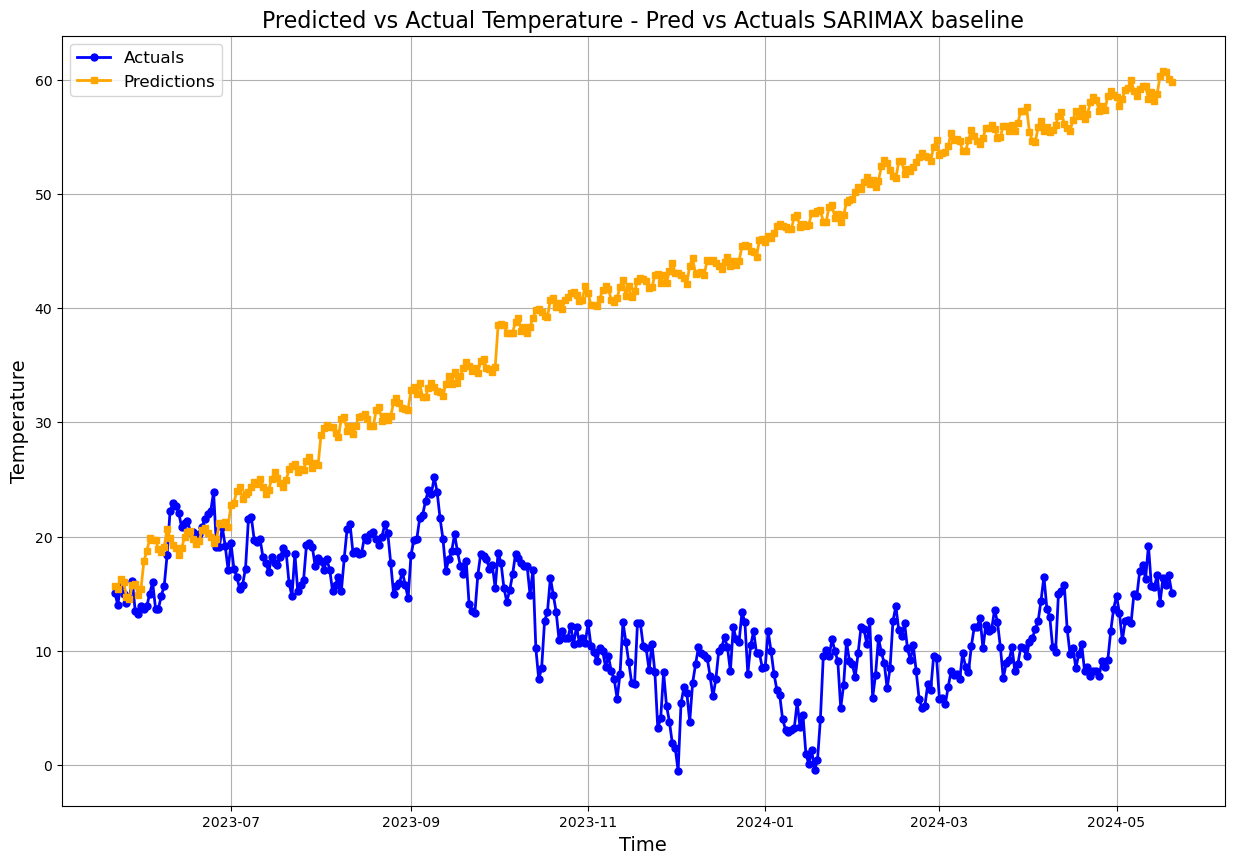

In [222]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['preds_sarimax']], 'Pred vs Actuals SARIMAX baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 4.2 SARIMAX baseline performance metrics

In [117]:
mae = mean_absolute_error(df_test['temp'], df_test_w_preds['preds_sarimax'])
mse = mean_squared_error(df_test['temp'], df_test_w_preds['preds_sarimax'])
rmse = np.sqrt(mse)
r2 = r2_score(df_test['temp'], df_test_w_preds['preds_sarimax'])

print(f"Mean Absolute Error (MAE) for SARIMAX: {mae}")
print(f"Mean Squared Error (MSE) for SARIMAX: {mse}")
print(f"Root Mean Squared Error (RMSE) for SARIMAX: {rmse}")
print(f"R-squared (R¬≤) for SARIMAX: {r2}")

Mean Absolute Error (MAE) for SARIMAX: 28.00612873173098
Mean Squared Error (MSE) for SARIMAX: 1045.717374171902
Root Mean Squared Error (RMSE) for SARIMAX: 32.337553620703936
R-squared (R¬≤) for SARIMAX: -36.939832749246925


### 4.3 SARIMAX GS

In [118]:
sarimax_results=df_test_w_preds.copy()

In [119]:
def gridsearch_sarimax(p,d,q,P,D,Q,S,df_results_sarimax): 
    start_time = time.time()
    print(p,d,q,P,D,Q,S)
    model_sarimax_baseline = StatsmodelsSARIMAX(
    endog=df_train_short['temp'],
    exog=df_train_short.drop('temp',axis=1).astype(float),
    order=(p,d,q),  
    seasonal_order=(P,D,Q,S))
    sarimax_base_results = model_sarimax_baseline.fit()
    forecast_sarimax = sarimax_base_results.get_forecast(steps=len(df_test), exog=df_test.drop('temp',axis=1).astype(float))
    df_results_sarimax[f"{p}_{d}_{q}_{P}_{D}_{Q}_{S}"]=forecast_sarimax.predicted_mean
    df_results_sarimax.to_csv(r"C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\sarimax_results.csv")
    end_time = time.time()
    time_sarimax_gs = end_time - start_time
    print(f"Model execution time for SARIMAX grid search: {time_sarimax_gs:.4f} seconds")
    return df_results_sarimax

In [120]:
p_values = range(0, 2)
d_values = [1]
q_values = range(0, 2)
P_values = range(0, 2)
D_values = [1]
Q_values = range(0, 2)
s_values = [12]

In [121]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            sarimax_results = gridsearch_sarimax(p,d,q,P,D,Q,s,sarimax_results)



0 1 0 0 1 0 12
Model execution time for SARIMAX grid search: 15.8195 seconds
0 1 0 0 1 1 12
Model execution time for SARIMAX grid search: 28.2263 seconds
0 1 0 1 1 0 12
Model execution time for SARIMAX grid search: 27.7118 seconds
0 1 0 1 1 1 12
Model execution time for SARIMAX grid search: 29.6042 seconds
0 1 1 0 1 0 12
Model execution time for SARIMAX grid search: 12.3472 seconds
0 1 1 0 1 1 12
Model execution time for SARIMAX grid search: 31.3874 seconds
0 1 1 1 1 0 12
Model execution time for SARIMAX grid search: 26.7234 seconds
0 1 1 1 1 1 12
Model execution time for SARIMAX grid search: 29.5094 seconds
1 1 0 0 1 0 12
Model execution time for SARIMAX grid search: 9.8848 seconds
1 1 0 0 1 1 12
Model execution time for SARIMAX grid search: 26.7708 seconds
1 1 0 1 1 0 12
Model execution time for SARIMAX grid search: 29.0040 seconds
1 1 0 1 1 1 12
Model execution time for SARIMAX grid search: 25.9124 seconds
1 1 1 0 1 0 12
Model execution time for SARIMAX grid search: 11.0551 seconds


In [122]:
sarimax_results.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1  6.9      64.3     0.0         0.0          0.0   0.0   
2023-05-23  14.0  6.1      60.6     0.0         0.0          0.0   0.0   
2023-05-24  15.8  6.7      61.2     0.0         0.0          0.0   0.0   
2023-05-25  15.0  6.7      57.9     0.0         0.0          0.0   0.0   
2023-05-26  14.2  6.9      63.5     0.0         0.0          0.0   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds   preds_gs  \
2023-05-22    False     False     False     False  14.492051  13.432552   
2023-05-23    False     False     False     False  17.870735  14.786562   
2023-05-24    False     False     False     False  16.441523  15.185232   
2023-05-25    False     False     False     False  14.017682  13.373943   
2023-05-26    False     False     False     False  13.380795  14.683416   

            sktime_naive  preds_autoarima  preds_sarimax  0_1_0_0_1_0_12  \
2023-05-22     14.401869        13.984044      15.701231       14.262505   
2023-05-23     14.403738        13.895126      15.439488       12.969671   
2023-05-24     14.405607        13.759057      16.274314       11.726274   
2023-05-25     14.407477        13.725513      16.052129       11.889092   
2023-05-26     14.409346        13.632718      14.740708       13.688463   

            0_1_0_0_1_1_12  0_1_0_1_1_0_12  0_1_0_1_1_1_12  0_1_1_0_1_0_12  \
2023-05-22       15.084606       16.262573       15.411402       14.014499   
2023-05-23       14.858931       15.027297       15.335364       12.774197   
2023-05-24       16.140163       14.934097       16.483676       11.545066   
2023-05-25       15.489129       15.749994       15.788281       11.703066   
2023-05-26       14.538317       15.236335       14.687503       13.499957   

            0_1_1_0_1_1_12  0_1_1_1_1_0_12  0_1_1_1_1_1_12  1_1_0_0_1_0_12  \
2023-05-22       15.492858       16.140950       15.804579       14.121793   
2023-05-23       15.358141       14.913157       15.525820       12.860826   
2023-05-24       16.183049       14.830746       16.374834       11.622223   
2023-05-25       15.760154       15.576497       16.164045       11.785514

In [123]:
# find the best SARIMAX GS to select one column 

In [124]:
for p in p_values: 
    for d in d_values:
        for q in q_values: 
            for P in P_values: 
                for D in D_values: 
                    for Q in Q_values: 
                        for s in s_values:
                            config = f"{p}_{d}_{q}_{P}_{D}_{Q}_{s}"
                            sarimax_results[f'ae_{config}'] = np.abs(sarimax_results['temp'] - sarimax_results[config])
                            #for each day it substracts the prediction from the actual temperature so it gets the error 

In [125]:
sarimax_results.head() #with the absolute error for all combos

temp   dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1   6.9      64.3   0.000         0.0         0.00   0.0   
2023-05-23  14.0   6.1      60.6   0.000         0.0         0.00   0.0   
2023-05-24  15.8   6.7      61.2   0.000         0.0         0.00   0.0   
2023-05-25  15.0   6.7      57.9   0.000         0.0         0.00   0.0   
2023-05-26  14.2   6.9      63.5   0.000         0.0         0.00   0.0   
...          ...   ...       ...     ...         ...          ...   ...   
2024-05-16  14.2  11.0      73.4   0.000         0.0         0.00   0.0   
2024-05-17  16.4  11.7      77.8   3.598       100.0        33.33   0.0   
2024-05-18  15.8  10.5      69.7   0.797       100.0         8.33   0.0   
2024-05-19  16.6  12.4      89.1  10.126       100.0        20.83   0.0   
2024-05-20  15.1  10.3      70.2   0.000         0.0         0.00   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   
...               ...       ...        ...      ...               ...   
2024-05-16        0.0      35.2       21.0    183.4            1007.1   
2024-05-17        0.0      30.5       21.0    149.7            1001.1   
2024-05-18        0.0      25.0       15.2    147.1            1004.2   
2024-05-19        0.0      18.4       10.1    213.9            1005.2   
2024-05-20        0.0      17.4        9.4    194.8            1009.3   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   
...                ...         ...             ...          ...      ...   
2024-05-16        86.1        14.9            71.5          6.2      2.0   
2024-05-17        85.6        15.4            76.1          6.5      4.0   
2024-05-18        52.3        19.4           118.8         10.3      9.0   
2024-05-19        58.3        15.8            74.5          6.5      3.0   
2024-05-20        41.4        21.7           177.8         15.5     10.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   
...                ...        ...                   ...   ...      ...   
2024-05-16        10.0       0.17                   1.0  2024    False   
2024-05-17        10.0       0.20                   0.0  2024    False   
2024-05-18        10.0       0.25                   0.0  2024    False   
2024-05-19        10.0       0.27                   0.0  2024    False   
2024-05-20        10.0       0.30                   1.0  2024    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True 

In [126]:
sarimax_results.mean()

temp                 12.998904
dew                   8.377260
humidity             75.371781
precip                1.770110
precipprob           59.178082
                       ...    
ae_1_1_0_1_1_1_12    28.091205
ae_1_1_1_0_1_0_12     4.393348
ae_1_1_1_0_1_1_12    24.759164
ae_1_1_1_1_1_0_12    29.614588
ae_1_1_1_1_1_1_12    28.006129
Length: 70, dtype: float64

In [127]:
sarimax_results.iloc[:, -16:].mean()

ae_0_1_0_0_1_0_12     5.655249
ae_0_1_0_0_1_1_12    11.234045
ae_0_1_0_1_1_0_12    32.784564
ae_0_1_0_1_1_1_12    17.499370
ae_0_1_1_0_1_0_12     4.017199
ae_0_1_1_0_1_1_12    25.624576
ae_0_1_1_1_1_0_12    31.228481
ae_0_1_1_1_1_1_12    28.492494
ae_1_1_0_0_1_0_12     4.565757
ae_1_1_0_0_1_1_12    25.542673
ae_1_1_0_1_1_0_12    32.174635
ae_1_1_0_1_1_1_12    28.091205
ae_1_1_1_0_1_0_12     4.393348
ae_1_1_1_0_1_1_12    24.759164
ae_1_1_1_1_1_0_12    29.614588
ae_1_1_1_1_1_1_12    28.006129
dtype: float64

## 5. LSTM (Long Short Term Memory)

### 5.1 Baseline model 

In [128]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df_london[['temp']])

In [129]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

def split_sequence(sequence, n_steps):
    xs, ys = [], []
    for i in range(len(sequence) - n_steps):
        x = sequence[i:i + n_steps]
        y = sequence[i + n_steps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [130]:
n_steps = 30
X_train, y_train= split_sequence(values, n_steps)
X_test, y_test = split_sequence(values, n_steps)

In [131]:
#number of steps will be the lagged features of 3

In [132]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [133]:
y_test #this is the series we're trying to predict, try to create a 3D feature set 

array([[0.25970149],
       [0.31940299],
       [0.32238806],
       ...,
       [0.56716418],
       [0.59104478],
       [0.54626866]])

In [134]:
# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [135]:
model_baseline = Sequential()
model_baseline.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model_baseline.add(LSTM(50))
model_baseline.add(Dense(1))
model_baseline.compile(optimizer='adam', loss='mean_squared_error')

In [136]:
start_time = time.time()

model_baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

end_time = time.time()
time_lstm_baseline = end_time - start_time
print(f"Model training time for LSTM baseline: {time_lstm_baseline:.2f} seconds")

Epoch 1/10
118/118 [==============================] - 11s 31ms/step - loss: 0.0165 - val_loss: 0.0069
Epoch 2/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 3/10
118/118 [==============================] - 3s 30ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 4/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 5/10
118/118 [==============================] - 3s 25ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 6/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 7/10
118/118 [==============================] - 3s 27ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 8/10
118/118 [==============================] - 3s 26ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 9/10
118/118 [==============================] - 3s 24ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 10/10
118/118 [==============================] - 3s 26ms/step - loss: 0.0033 - val_l

In [137]:
def predict_future(model, data, n_steps, predict_n_days):
    prediction_list = data[-n_steps:].tolist()
    prediction_list = [item[0] for item in prediction_list]
    
    for _ in range(predict_n_days):
        x = np.array(prediction_list[-n_steps:]).reshape((1, n_steps, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)

    # transforms the predictions back to the original scale
    prediction_list = scaler.inverse_transform(np.array(prediction_list).reshape(-1, 1))
    return prediction_list

In [138]:
predict_n_days = 365

In [139]:
yhat_baseline = predict_future(model_baseline, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 25ms/step


In [140]:
yhat_baseline[n_steps:]

array([[15.48014783],
       [15.85135667],
       [16.18030419],
       [16.46649517],
       [16.70113193],
       [16.9177859 ],
       [17.10742177],
       [17.2674817 ],
       [17.42119794],
       [17.57471051],
       [17.71257849],
       [17.84078618],
       [17.96474876],
       [18.09681218],
       [18.2320704 ],
       [18.3627321 ],
       [18.49346368],
       [18.62468048],
       [18.75536813],
       [18.88444241],
       [19.01249434],
       [19.14486726],
       [19.27471228],
       [19.4086826 ],
       [19.53945013],
       [19.67496594],
       [19.80777414],
       [19.95460756],
       [20.09827413],
       [20.22518592],
       [20.36242892],
       [20.48985787],
       [20.62640401],
       [20.77066361],
       [20.89948429],
       [21.03095468],
       [21.16128691],
       [21.29352205],
       [21.41997858],
       [21.55421447],
       [21.69147145],
       [21.8297288 ],
       [21.95273294],
       [22.08576079],
       [22.21459545],
       [22

In [141]:
len(yhat_baseline[n_steps:])

365

In [142]:
df_test_w_preds['lstm_base'] = yhat_baseline[n_steps:]
df_test_w_preds.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1  6.9      64.3     0.0         0.0          0.0   0.0   
2023-05-23  14.0  6.1      60.6     0.0         0.0          0.0   0.0   
2023-05-24  15.8  6.7      61.2     0.0         0.0          0.0   0.0   
2023-05-25  15.0  6.7      57.9     0.0         0.0          0.0   0.0   
2023-05-26  14.2  6.9      63.5     0.0         0.0          0.0   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds   preds_gs  \
2023-05-22    False     False     False     False  14.492051  13.432552   
2023-05-23    False     False     False     False  17.870735  14.786562   
2023-05-24    False     False     False     False  16.441523  15.185232   
2023-05-25    False     False     False     False  14.017682  13.373943   
2023-05-26    False     False     False     False  13.380795  14.683416   

            sktime_naive  preds_autoarima  preds_sarimax  lstm_base  
2023-05-22     14.401869        13.984044      15.701231  15.480148  
2023-05-23     14.403738        13.895126      15.439488  15.851357  
2023-05-24     14.405607        13.759057      16.274314  16.180304  
2023-05-25     14.407477        13.725513      16.052129  16.466495  
2023-05-26     14.409346        13.632718      14.740708  16.701132

In [143]:
# the model is very weak and it's predicting the same 200+ temperature. it needs improving with additiona layers

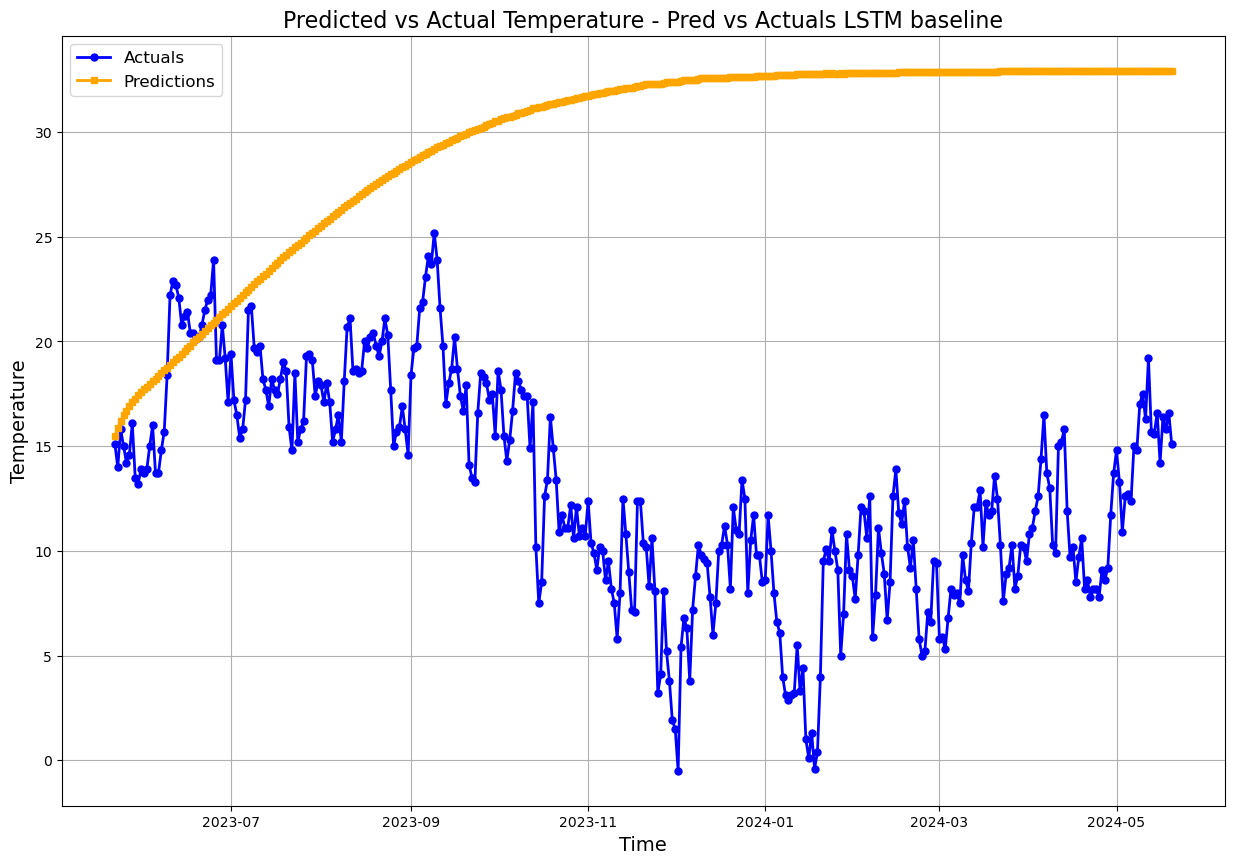

In [223]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_base']], 'Pred vs Actuals LSTM baseline', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 5.2 LSTM baseline performance metrics

In [145]:
y_true = df_test_w_preds['temp'].values  
y_pred = df_test_w_preds['lstm_base'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'R-squared Score (R¬≤): {r2:.2f}')

Mean Absolute Error (MAE): 16.71
Mean Squared Error (MSE): 354.16
Root Mean Squared Error (RMSE): 18.82
Mean Absolute Percentage Error (MAPE): 353.13%
R-squared Score (R¬≤): -11.85


### 5.3 Improved layers - LSTM

In [146]:
model_lstm_two = Sequential()
model_lstm_two.add(LSTM(100, return_sequences=True, input_shape=(n_steps, 1)))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(LSTM(100, return_sequences=False))
model_lstm_two.add(Dropout(0.2))

model_lstm_two.add(Dense(50, activation='relu'))

model_lstm_two.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_two.compile(optimizer=optimizer, loss='mean_squared_error')

start_time = time.time()
history = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_layers = end_time - start_time
print(f"Model training time: {time_lstm_layers:.2f} seconds")

Epoch 1/3
118/118 [==============================] - 8s 32ms/step - loss: 0.0169 - val_loss: 0.0068
Epoch 2/3
118/118 [==============================] - 3s 27ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 3/3
118/118 [==============================] - 3s 28ms/step - loss: 0.0069 - val_loss: 0.0057
Model training time: 14.27 seconds


In [147]:
yhat_lstm_two = predict_future(model_lstm_two, values, n_steps, predict_n_days)

1/1 [==============================] - 0s 33ms/step


In [148]:
df_test_w_preds['lstm_two_layers'] = yhat_lstm_two[n_steps:]
df_test_w_preds.head()

temp  dew  humidity  precip  precipprob  precipcover  snow  \
2023-05-22  15.1  6.9      64.3     0.0         0.0          0.0   0.0   
2023-05-23  14.0  6.1      60.6     0.0         0.0          0.0   0.0   
2023-05-24  15.8  6.7      61.2     0.0         0.0          0.0   0.0   
2023-05-25  15.0  6.7      57.9     0.0         0.0          0.0   0.0   
2023-05-26  14.2  6.9      63.5     0.0         0.0          0.0   0.0   

            snowdepth  windgust  windspeed  winddir  sealevelpressure  \
2023-05-22        0.0      26.1       17.5     61.3            1027.2   
2023-05-23        0.0      36.4       21.3     40.6            1025.3   
2023-05-24        0.0      34.7       20.0     30.7            1021.7   
2023-05-25        0.0      41.5       23.9     12.1            1021.2   
2023-05-26        0.0      26.1       17.3     36.0            1026.5   

            cloudcover  visibility  solarradiation  solarenergy  uvindex  \
2023-05-22        55.6        27.2            99.0          8.7      4.0   
2023-05-23        40.0        27.5           192.2         16.3      9.0   
2023-05-24        43.9        35.0           156.4         13.6      7.0   
2023-05-25        62.5        37.2            80.0          7.0      3.0   
2023-05-26        27.0        29.2           147.4         12.5      7.0   

            severerisk  moonphase  clusters_description  year  month_1  \
2023-05-22        10.0       0.00                   1.0  2023    False   
2023-05-23        10.0       0.03                   1.0  2023    False   
2023-05-24        10.0       0.06                   1.0  2023    False   
2023-05-25        10.0       0.09                   1.0  2023    False   
2023-05-26        10.0       0.12                   0.0  2023    False   

            month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
2023-05-22    False    False    False     True    False    False    False   
2023-05-23    False    False    False     True    False    False    False   
2023-05-24    False    False    False     True    False    False    False   
2023-05-25    False    False    False     True    False    False    False   
2023-05-26    False    False    False     True    False    False    False   

            month_9  month_10  month_11  month_12      preds   preds_gs  \
2023-05-22    False     False     False     False  14.492051  13.432552   
2023-05-23    False     False     False     False  17.870735  14.786562   
2023-05-24    False     False     False     False  16.441523  15.185232   
2023-05-25    False     False     False     False  14.017682  13.373943   
2023-05-26    False     False     False     False  13.380795  14.683416   

            sktime_naive  preds_autoarima  preds_sarimax  lstm_base  \
2023-05-22     14.401869        13.984044      15.701231  15.480148   
2023-05-23     14.403738        13.895126      15.439488  15.851357   
2023-05-24     14.405607        13.759057      16.274314  16.180304   
2023-05-25     14.407477        13.725513      16.052129  16.466495   
2023-05-26     14.409346        13.632718      14.740708  16.701132   

            lstm_two_layers  
2023-05-22        15.761465  
2023-05-23        15.734922  
2023-05-24        15.717550  
2023-05-25        15.707445  
2023-05-26        15.701181

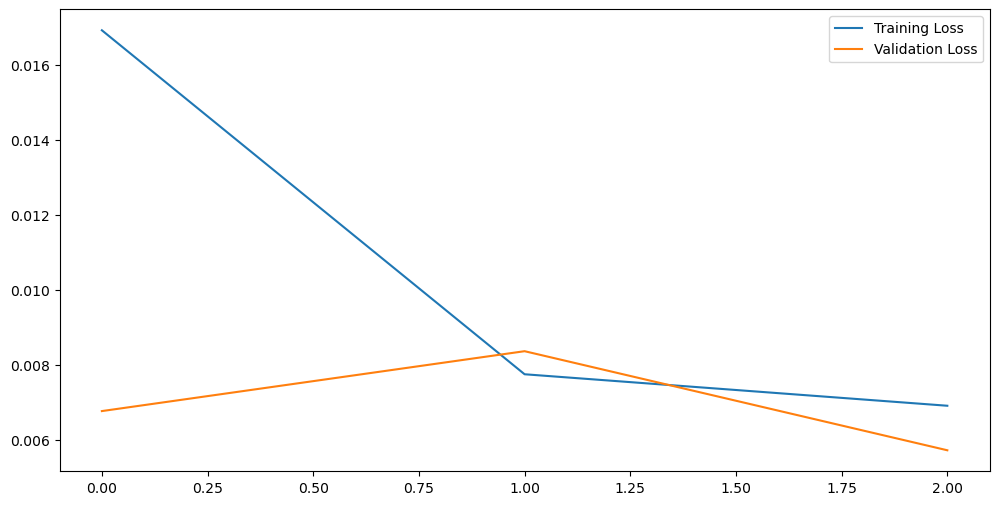

<Figure size 640x480 with 0 Axes>

In [149]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

save_path = r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images\LSTM_baseline_training_loss.png'
plt.savefig(save_path, bbox_inches='tight') 

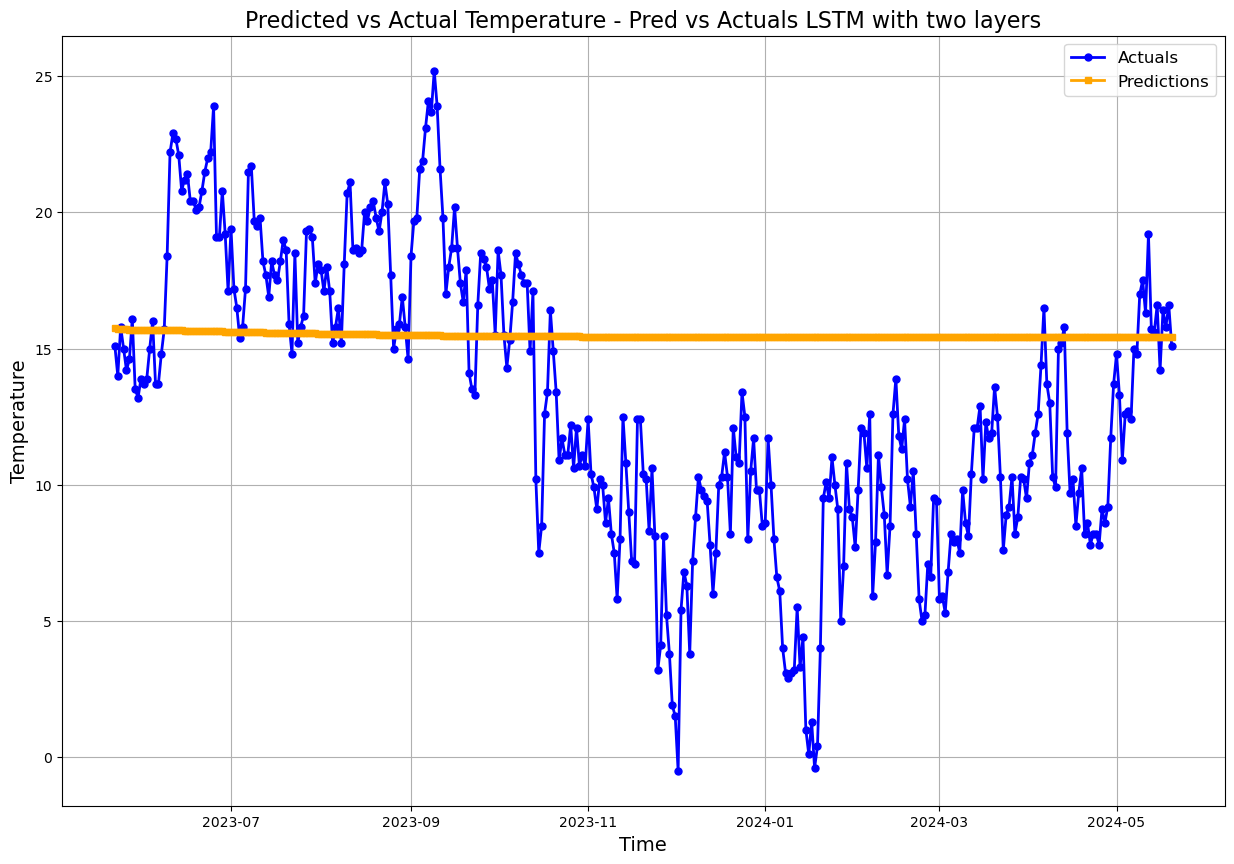

In [224]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_two_layers']], 'Pred vs Actuals LSTM with two layers', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 5.4 LSTM improved layers performance metrics

In [151]:
y_true = df_test_w_preds['temp'].values
y_pred_lstm_two = df_test_w_preds['lstm_two_layers'].values

mae_value_lstm_two = mean_absolute_error(y_true, y_pred_lstm_two)
mse_value_lstm_two = mean_squared_error(y_true, y_pred_lstm_two)
rmse_value_lstm_two = np.sqrt(mse_value_lstm_two)
mape_value_lstm_two = np.mean(np.abs((y_true - y_pred_lstm_two) / y_true)) * 100
r2_value_lstm_two = r2_score(y_true, y_pred_lstm_two)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_two:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_two:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_two:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_two:.2f}%')
print(f'R-squared Score (R¬≤): {r2_value_lstm_two:.2f}')

Mean Absolute Error (MAE): 4.76
Mean Squared Error (MSE): 33.29
Root Mean Squared Error (RMSE): 5.77
Mean Absolute Percentage Error (MAPE): 134.45%
R-squared Score (R¬≤): -0.21


### 5.5 Tuning batch size for LSTM

In [152]:
start_time = time.time()
history_batchsize_1 = model_lstm_two.fit(X_train, y_train, epochs=3, batch_size=1, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_batch = end_time - start_time
print(f"Model training time for LSTM batch: {time_lstm_batch:.2f} seconds")

Epoch 1/3
3763/3763 [==============================] - 85s 23ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 2/3
3763/3763 [==============================] - 85s 22ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 3/3
3763/3763 [==============================] - 92s 25ms/step - loss: 0.0040 - val_loss: 0.0033
Model training time for LSTM batch: 261.75 seconds


In [153]:
yhat_lstm_batch_1 = predict_future(model_lstm_two, values, n_steps, predict_n_days)


1/1 [==============================] - 0s 26ms/step


In [154]:
df_test_w_preds['lstm_two_layers_batch_size_1'] = yhat_lstm_batch_1[n_steps:]


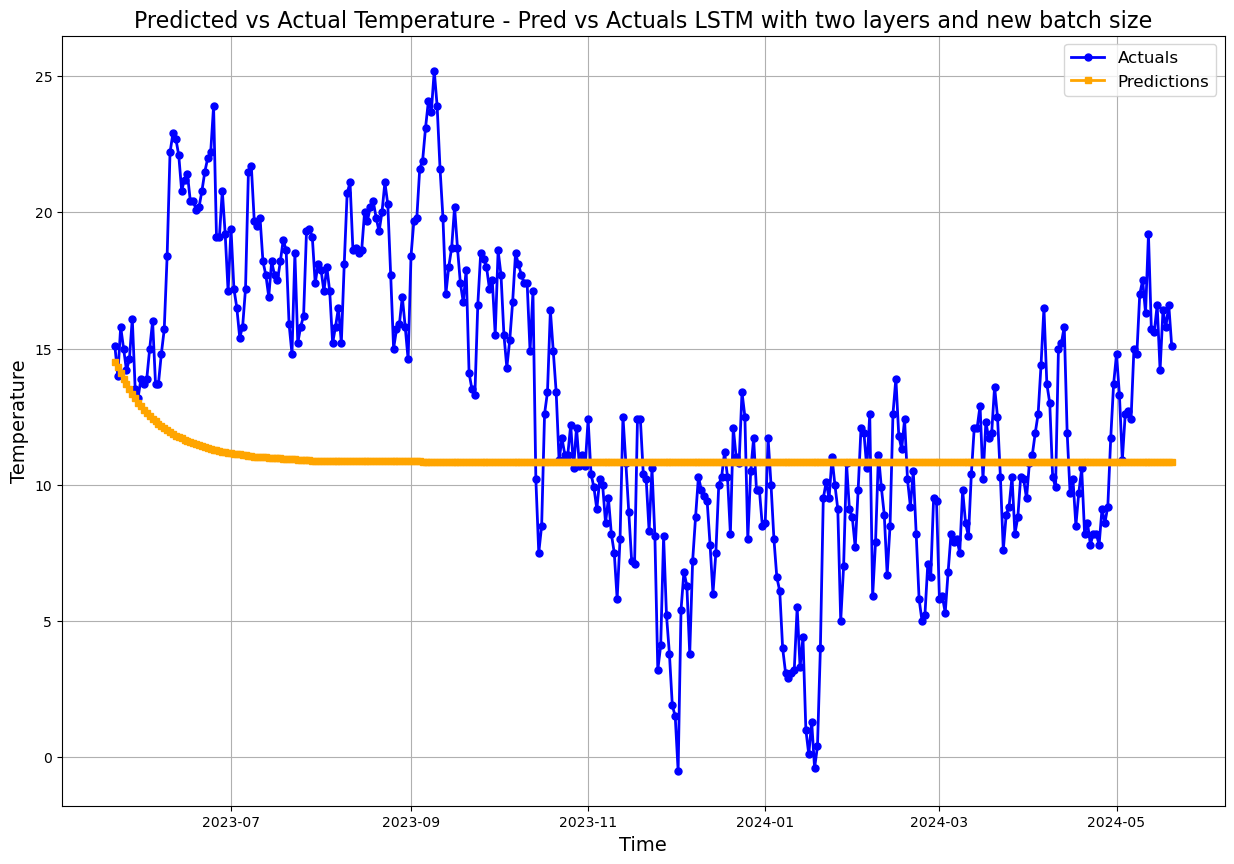

In [225]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_two_layers_batch_size_1']], 'Pred vs Actuals LSTM with two layers and new batch size', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

### 5.6. Batch size LSTM performance metrics

In [156]:
# Assuming 'actual_temp' contains the actual temperature values for the same period as the predictions
y_true = df_test_w_preds['temp'].values  # Replace with the actual column name if different
y_pred_lstm_batch_1 = df_test_w_preds['lstm_two_layers_batch_size_1'].values

# Calculate each performance metric
mae_value_lstm_batch_1 = mean_absolute_error(y_true, y_pred_lstm_batch_1)
mse_value_lstm_batch_1 = mean_squared_error(y_true, y_pred_lstm_batch_1)
rmse_value_lstm_batch_1 = np.sqrt(mse_value_lstm_batch_1)
mape_value_lstm_batch_1 = np.mean(np.abs((y_true - y_pred_lstm_batch_1) / y_true)) * 100
r2_value_lstm_batch_1 = r2_score(y_true, y_pred_lstm_batch_1)

# Print the results
print(f'Mean Absolute Error (MAE): {mae_value_lstm_batch_1:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_batch_1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_batch_1:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_batch_1:.2f}%')
print(f'R-squared Score (R¬≤): {r2_value_lstm_batch_1:.2f}')

Mean Absolute Error (MAE): 4.44
Mean Squared Error (MSE): 30.67
Root Mean Squared Error (RMSE): 5.54
Mean Absolute Percentage Error (MAPE): 93.44%
R-squared Score (R¬≤): -0.11


### 5.7 LSTM with added features

In [157]:
def split_sequence(features, target, n_steps):
    xs, ys = [], []
    
    # loop through the data to create sequences
    for i in range(len(features) - n_steps):
        # extract sequences of features and the corresponding target
        x = features[i:i + n_steps]
        y = target[i + n_steps]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)


In [158]:
df_train = df_train.astype(float)
df_test = df_test.astype(float)

In [159]:
X_train, y_train= split_sequence(df_train.drop(['temp'], axis=1),df_train['temp'], n_steps)
X_test, y_test = split_sequence(df_test.drop(['temp'], axis=1),df_test['temp'], n_steps)

In [160]:
model_lstm_features = Sequential()
model_lstm_features.add(LSTM(100, return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model_lstm_features.add(Dropout(0.2))

model_lstm_features.add(LSTM(100, return_sequences=False))
model_lstm_features.add(Dropout(0.2))

model_lstm_features.add(Dense(50, activation='relu'))

model_lstm_features.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model_lstm_features.compile(optimizer=optimizer, loss='mean_squared_error')

start_time = time.time()
history = model_lstm_features.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
time_lstm_features = end_time - start_time
print(f"Model training time for LSTM with features: {time_lstm_features:.2f} seconds")

Epoch 1/3
107/107 [==============================] - 7s 31ms/step - loss: 39.1814 - val_loss: 27.6500
Epoch 2/3
107/107 [==============================] - 2s 19ms/step - loss: 29.1773 - val_loss: 27.4546
Epoch 3/3
107/107 [==============================] - 2s 21ms/step - loss: 29.2664 - val_loss: 27.5109
Model training time for LSTM with features: 11.08 seconds


In [161]:
def get_predictions(model, X_test):
    predictions = model.predict(X_test)
    
    # since the model outputs a 2D array (batch_size, 1), we'll flatten it to match the shape of the y_test
    return predictions.flatten()


In [162]:
preds = np.concatenate([X_train[-30:], X_test])

In [163]:
predictions = get_predictions(model_lstm_features, preds)


12/12 [==============================] - 1s 13ms/step


In [164]:
predictions

array([12.103012 , 12.118535 , 12.126768 , 12.10311  , 12.119196 ,
       12.102813 , 12.119705 , 12.132345 , 12.104645 , 12.108422 ,
       12.114841 , 12.123908 , 12.126531 , 12.1271   , 12.120851 ,
       12.125273 , 12.126826 , 12.127187 , 12.120465 , 12.125041 ,
       12.126697 , 12.127127 , 12.12722  , 12.127242 , 12.105061 ,
       12.099467 , 12.118992 , 12.125499 , 12.12692  , 12.127219 ,
       12.127406 , 12.127251 , 12.127231 , 12.127249 , 12.127247 ,
       12.127249 , 12.127248 , 12.127248 , 12.127247 , 12.127249 ,
       12.127247 , 12.127247 , 12.127247 , 12.127247 , 12.127247 ,
       12.127247 , 12.127248 , 12.127248 , 12.127248 , 12.127248 ,
       12.127248 , 12.127248 , 12.127248 , 12.127248 , 12.127248 ,
       12.127248 , 12.127248 , 12.103252 , 12.119722 , 12.125609 ,
       12.126935 , 12.127206 , 12.127234 , 12.127242 , 12.127244 ,
       12.127246 , 12.127248 , 12.126902 , 12.127175 , 12.127231 ,
       12.127249 , 12.127249 , 12.127249 , 12.127248 , 12.1272

In [165]:
df_test_w_preds['temp'].values

array([15.1, 14. , 15.8, 15. , 14.2, 14.6, 16.1, 13.5, 13.2, 13.9, 13.7,
       13.9, 15. , 16. , 13.7, 13.7, 14.8, 15.7, 18.4, 22.2, 22.9, 22.7,
       22.1, 20.8, 21.2, 21.4, 20.4, 20.4, 20.1, 20.2, 20.8, 21.5, 22. ,
       22.2, 23.9, 19.1, 19.1, 20.8, 19.2, 17.1, 19.4, 17.2, 16.5, 15.4,
       15.8, 17.2, 21.5, 21.7, 19.7, 19.5, 19.8, 18.2, 17.7, 16.9, 18.2,
       17.7, 17.5, 18.2, 19. , 18.6, 15.9, 14.8, 18.5, 15.2, 15.8, 16.2,
       19.3, 19.4, 19.1, 17.4, 18.1, 17.9, 17.1, 18. , 17.1, 15.2, 15.8,
       16.5, 15.2, 18.1, 20.7, 21.1, 18.6, 18.7, 18.5, 18.6, 20. , 19.7,
       20.2, 20.4, 19.8, 19.3, 20. , 21.1, 20.3, 17.7, 15. , 15.7, 15.9,
       16.9, 15.8, 14.6, 18.4, 19.7, 19.8, 21.6, 21.9, 23.1, 24.1, 23.7,
       25.2, 23.9, 21.6, 19.8, 17. , 18. , 18.7, 20.2, 18.7, 17.4, 16.7,
       17.9, 14.1, 13.5, 13.3, 16.6, 18.5, 18.3, 18. , 17.2, 17.5, 15.5,
       18.6, 17.7, 15.5, 14.3, 15.3, 16.7, 18.5, 18.1, 17.7, 17.4, 17.4,
       14.9, 17.1, 10.2,  7.5,  8.5, 12.6, 13.4, 16

In [166]:
df_test_w_preds['lstm_features'] = predictions


In [167]:
df_test_w_preds[['temp','lstm_features']]

temp  lstm_features
2023-05-22  15.1      12.103012
2023-05-23  14.0      12.118535
2023-05-24  15.8      12.126768
2023-05-25  15.0      12.103110
2023-05-26  14.2      12.119196
...          ...            ...
2024-05-16  14.2      12.127045
2024-05-17  16.4      12.103642
2024-05-18  15.8      12.101191
2024-05-19  16.6      12.119596
2024-05-20  15.1      12.124742

[365 rows x 2 columns]

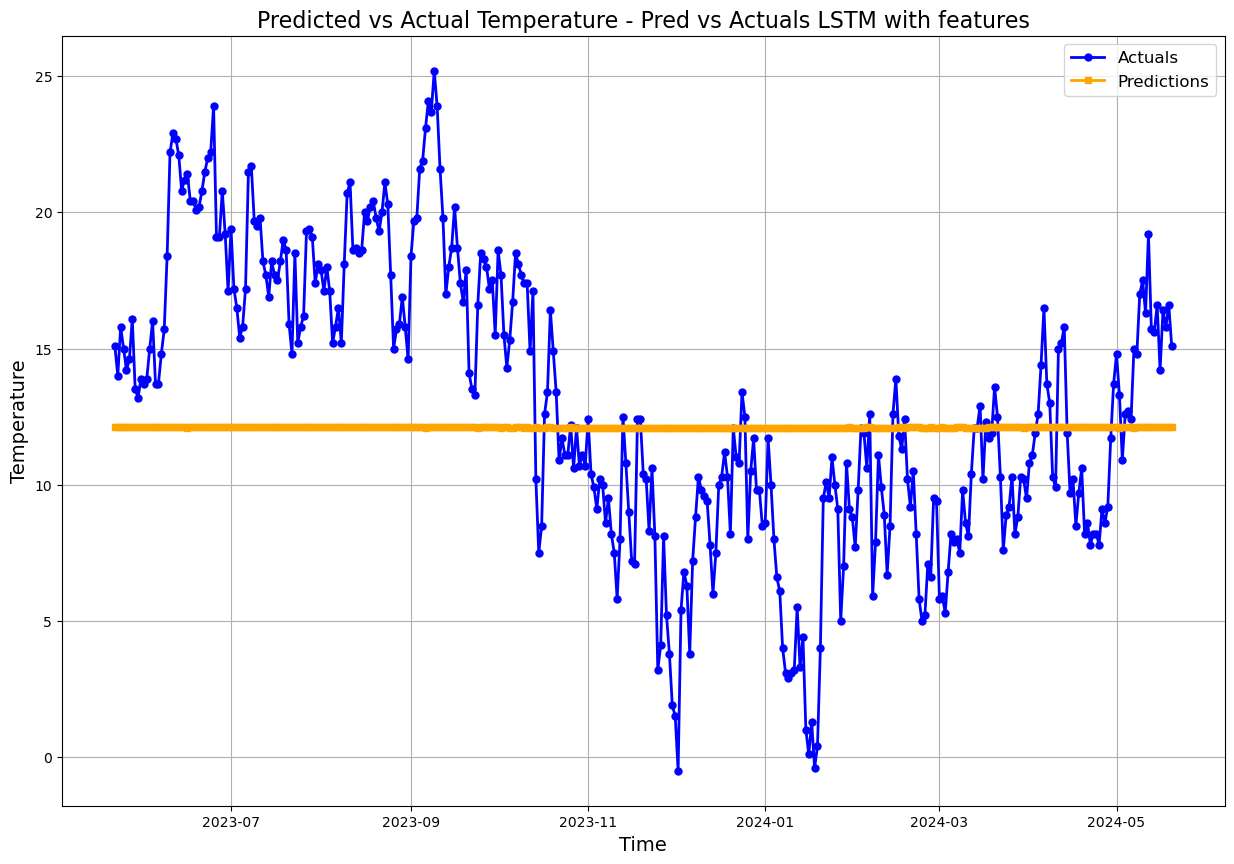

In [226]:
plot_forecast(df_test_w_preds[['temp']], df_test_w_preds[['lstm_features']], 'Pred vs Actuals LSTM with features', save_path=r'C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\images')

In [169]:
#performance metrics

In [170]:
y_true = df_test_w_preds['temp'].values  
y_pred_lstm_features = df_test_w_preds['lstm_features'].values

mae_value_lstm_features = mean_absolute_error(y_true, y_pred_lstm_features)
mse_value_lstm_features = mean_squared_error(y_true, y_pred_lstm_features)
rmse_value_lstm_features = np.sqrt(mse_value_lstm_features)
mape_value_lstm_features = np.mean(np.abs((y_true - y_pred_lstm_features) / y_true)) * 100
r2_value_lstm_features = r2_score(y_true, y_pred_lstm_features)

print(f'Mean Absolute Error (MAE): {mae_value_lstm_features:.2f}')
print(f'Mean Squared Error (MSE): {mse_value_lstm_features:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_value_lstm_features:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_value_lstm_features:.2f}%')
print(f'R-squared Score (R¬≤): {r2_value_lstm_features:.2f}')

Mean Absolute Error (MAE): 4.42
Mean Squared Error (MSE): 28.26
Root Mean Squared Error (RMSE): 5.32
Mean Absolute Percentage Error (MAPE): 103.58%
R-squared Score (R¬≤): -0.03


## 6. Concatenating final SARIMAX results in the df with all predictions

In [171]:
df_test_w_preds['sarimax_gs'] = sarimax_results['ae_0_1_1_0_1_0_12']

In [172]:
# ae_0_1_1_0_1_0_12 is the best combination of parameters 

In [173]:
df_test_w_preds.to_csv(r"C:\Users\nicol\OneDrive\Master\Goldsmiths\Thesis\weather-prediction\data\df_with_all_preds.csv")

## 7. Time all models

In [174]:
# defining the results of the Naive Forecaster GS and the SARIMAX GS since they have multiple outputs 

time_nf_mean = 0.1341
time_nf_drift = 0.1911
time_nf_last = 0.0208 

#best combination of the SARIMAX GS outputs
time_sarimax_best = 12.5681 

In [175]:
execution_times = {
    'XGBoost Baseline': time_xgboost_baseline, 
    'XGBoost Grid search': time_xgboost_gs, 
    'Naive Forecaster Baseline': time_naive_baseline,
    'Naive Forecaster Mean strategy': time_nf_mean,
    'Naive Forecaster Drift strategy': time_nf_drift,
    'Naive Forecaster Last strategy': time_nf_last,
    'Auto-ARIMA': time_autoarima_baseline,
    'SARIMAX Baseline': time_sarimax_baseline,
    'SARIMAX Best combination': time_sarimax_best,
    'LSTM Baseline': time_lstm_baseline,
    'LSTM Improved Layers': time_lstm_layers,
    'LSTM Batch Size': time_lstm_batch,
    'LSTM with features': time_lstm_features,
}

time_results = pd.DataFrame(list(execution_times.items()), columns=['Model', 'Execution Time (seconds)'])

In [176]:
time_results

Model  Execution Time (seconds)
0                  XGBoost Baseline                  0.929545
1               XGBoost Grid search                 71.355647
2         Naive Forecaster Baseline                  0.003996
3    Naive Forecaster Mean strategy                  0.134100
4   Naive Forecaster Drift strategy                  0.191100
5    Naive Forecaster Last strategy                  0.020800
6                        Auto-ARIMA                 83.155132
7                  SARIMAX Baseline                 28.677047
8          SARIMAX Best combination                 12.568100
9                     LSTM Baseline                 37.788635
10             LSTM Improved Layers                 14.270877
11                  LSTM Batch Size                261.754320
12               LSTM with features                 11.082241

In [177]:
# pip freeze > requirements.txt